# Benchmark Analysis - H7

In [22]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [24]:
matplotlib.style.use('seaborn-v0_8')  

In [25]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [26]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [27]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [28]:
plot_save_dir = './plots/h7'

## Utils 

In [29]:
def get_path(*entries):
    return os.path.join(*entries)

In [30]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [31]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [32]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [33]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO", include_bytes=False) -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP,include_bytes_per_second=include_bytes)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [34]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [35]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [36]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [37]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [38]:
def get_strong_scaling_algo(compiler_location:str,
                            compiler_name:str,
                            bench_name:str,
                            base_of:Optional[str] = None) -> pd.DataFrame:
    
    seq_base = None

    if base_of:
        # base it of a other file and not the own sec
        seq_base = get_seq_base(base_of)
    else:
        ## seq base
        seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

In [39]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str,exec_suffix:str='par') -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}_{exec_suffix}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

In [40]:
def justify(a, invalid_val=0, axis=1, side='left'):    
    """
    Justifies a 2D array

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """

    if invalid_val is np.nan:
        #change to notnull
        mask = pd.notnull(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    #change dtype to object
    out = np.full(a.shape, invalid_val, dtype=object)  
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [41]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

strong_scale_base = 'b7_1_copy'


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [42]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,5840.46,4,5830.84,11123.6,9643.56
1,15925.30,8,11198.10,11402.7,10169.00
2,21501.40,16,16649.10,11570.3,11955.80
3,24983.00,32,23280.20,12092.3,11500.60
4,26178.00,64,26529.00,12882.3,12023.10
5,28571.40,128,27773.10,12783.1,11505.60
6,35149.80,256,30729.10,12604.3,11732.50
7,36898.80,512,33631.60,12755.7,11717.50
8,40729.80,1024,37579.90,12763.1,11437.50
9,45127.90,2048,42477.10,12812.7,12157.10


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [43]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.702946,0.286073,0.078201,0.036496
1,2,0.921453,0.500878,0.155679,0.072099
2,4,1.991957,1.047860,0.312241,0.164155
3,8,2.334162,1.608736,0.622731,0.280916
4,16,2.851105,2.035453,1.245162,0.653490
5,32,3.038772,2.221813,2.459470,1.226217
6,64,2.903951,2.203744,4.739396,1.348989


In [44]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.702946,0.286073,0.078201,0.036496
1,2,0.460727,0.250439,0.077839,0.036049
2,4,0.497989,0.261965,0.078060,0.041039
3,8,0.291770,0.201092,0.077841,0.035114
4,16,0.178194,0.127216,0.077823,0.040843
5,32,0.094962,0.069432,0.076858,0.038319
6,64,0.045374,0.034434,0.074053,0.021078


### Mbytes/s

In [45]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_1_bytes_merged = pd.merge(b7_1_bytes_merged,data[i], on='n')

b7_1_bytes_merged

,n,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,4,5.47902,5.48806,2.87677,3.31828
1,8,4.01876,5.71524,5.61271,6.29364
2,16,5.95310,7.68811,11.06280,10.70610
3,32,10.24700,10.99650,21.17060,22.25970
4,64,19.55840,19.29970,39.74450,42.58460
5,128,35.84000,36.87020,80.10600,89.00020
6,256,58.26490,66.64700,162.48400,174.55700
7,512,111.00600,121.79000,321.11100,349.56200
8,1024,201.13000,217.98900,641.84800,716.24100
9,2048,363.05700,385.71400,1278.74000,1347.69000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/3501768566.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


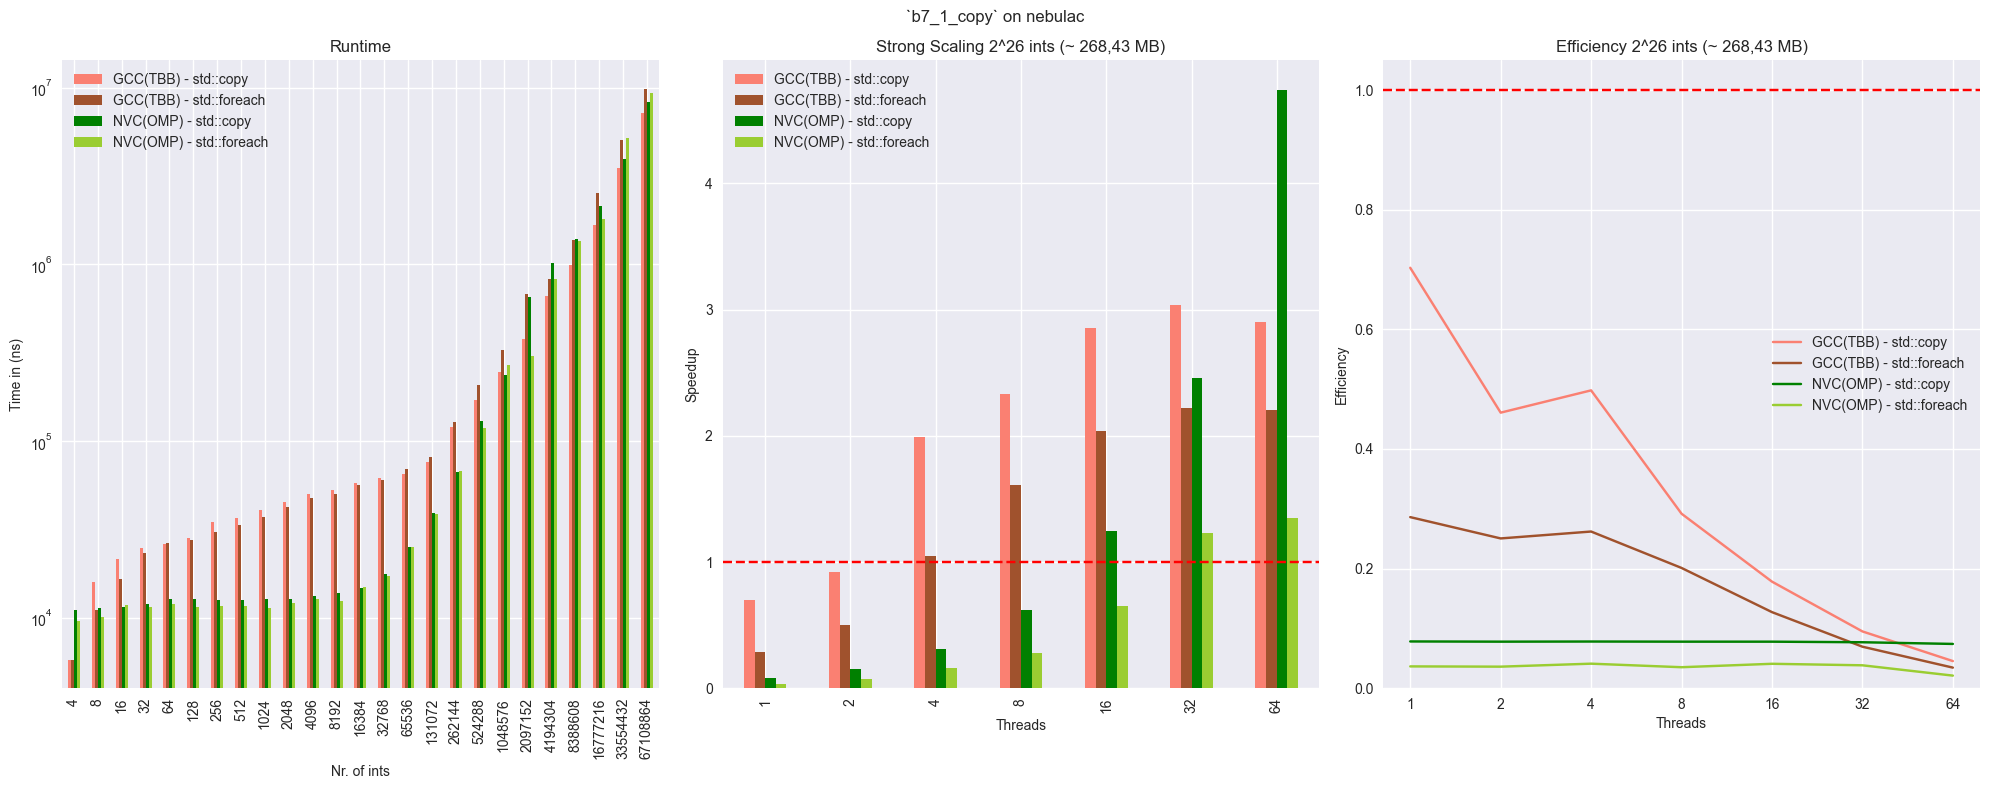

In [46]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,2.75)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_1_copy` on {device_name}")

fig.tight_layout()

plot(f"`b7_1_copy` {device_name}")

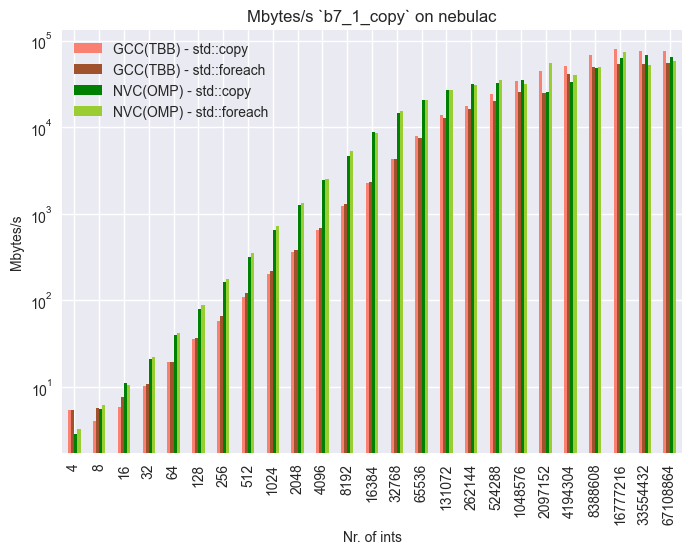

In [47]:
# mybtes graph


b7_1_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                    )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_1_copy` on {device_name}')


plot(f'`b7_1_copy` Mbytes_s on {device_name}')

## `b7_2` -  all_true

In [48]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_all_true'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [49]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5324.3,4,2670.18,42852.6,23545.3
1,11538.4,8,8896.87,39681.3,23448.5
2,18831.8,16,15223.90,47242.3,23958.3
3,24111.9,32,21170.50,46001.2,24977.1
4,27969.1,64,26925.50,47660.8,26396.2
5,30373.7,128,30952.20,46588.8,26303.0
6,31624.4,256,33345.70,46737.3,26599.7
7,33875.3,512,30995.40,46961.2,26648.0
8,37253.4,1024,36331.30,47645.1,26345.2
9,41106.2,2048,37367.60,48831.3,26133.8


### Strong Scaling - all true
 
2^26 fixed input size with threads 1-64

In [50]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.107371,0.746140,0.310537,0.417699
1,2,2.092306,1.514313,0.611189,0.830814
2,4,3.529431,2.843777,1.166425,1.651256
3,8,5.173539,4.608834,2.016816,3.279715
4,16,7.651538,7.396930,2.200737,6.465572
5,32,8.619810,8.570298,2.177485,12.609431
6,64,8.855009,9.159745,2.565854,14.019138


In [51]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.107371,0.746140,0.310537,0.417699
1,2,1.046153,0.757156,0.305594,0.415407
2,4,0.882358,0.710944,0.291606,0.412814
3,8,0.646692,0.576104,0.252102,0.409964
4,16,0.478221,0.462308,0.137546,0.404098
5,32,0.269369,0.267822,0.068046,0.394045
6,64,0.138360,0.143121,0.040091,0.219049


### Mbytes/s

In [52]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_all_true_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_all_true_bytes_merged = pd.merge(b7_2_all_true_bytes_merged,data[i], on='n')

b7_2_all_true_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.00509,11.98420,0.373373,1.35908
1,8,2.77336,7.19354,0.806426,2.72939
2,16,3.39851,8.40784,1.354720,5.34261
3,32,5.30858,12.09230,2.782530,10.24940
4,64,9.15296,19.01540,5.371280,19.39670
5,128,16.85670,33.08330,10.989800,38.93100
6,256,32.38000,61.41720,21.909700,76.99330
7,512,60.45700,132.14800,43.610500,153.70800
8,1024,109.95000,225.48100,85.968900,310.94900
9,2048,199.28900,438.45500,167.761000,626.92900


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/1266373404.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


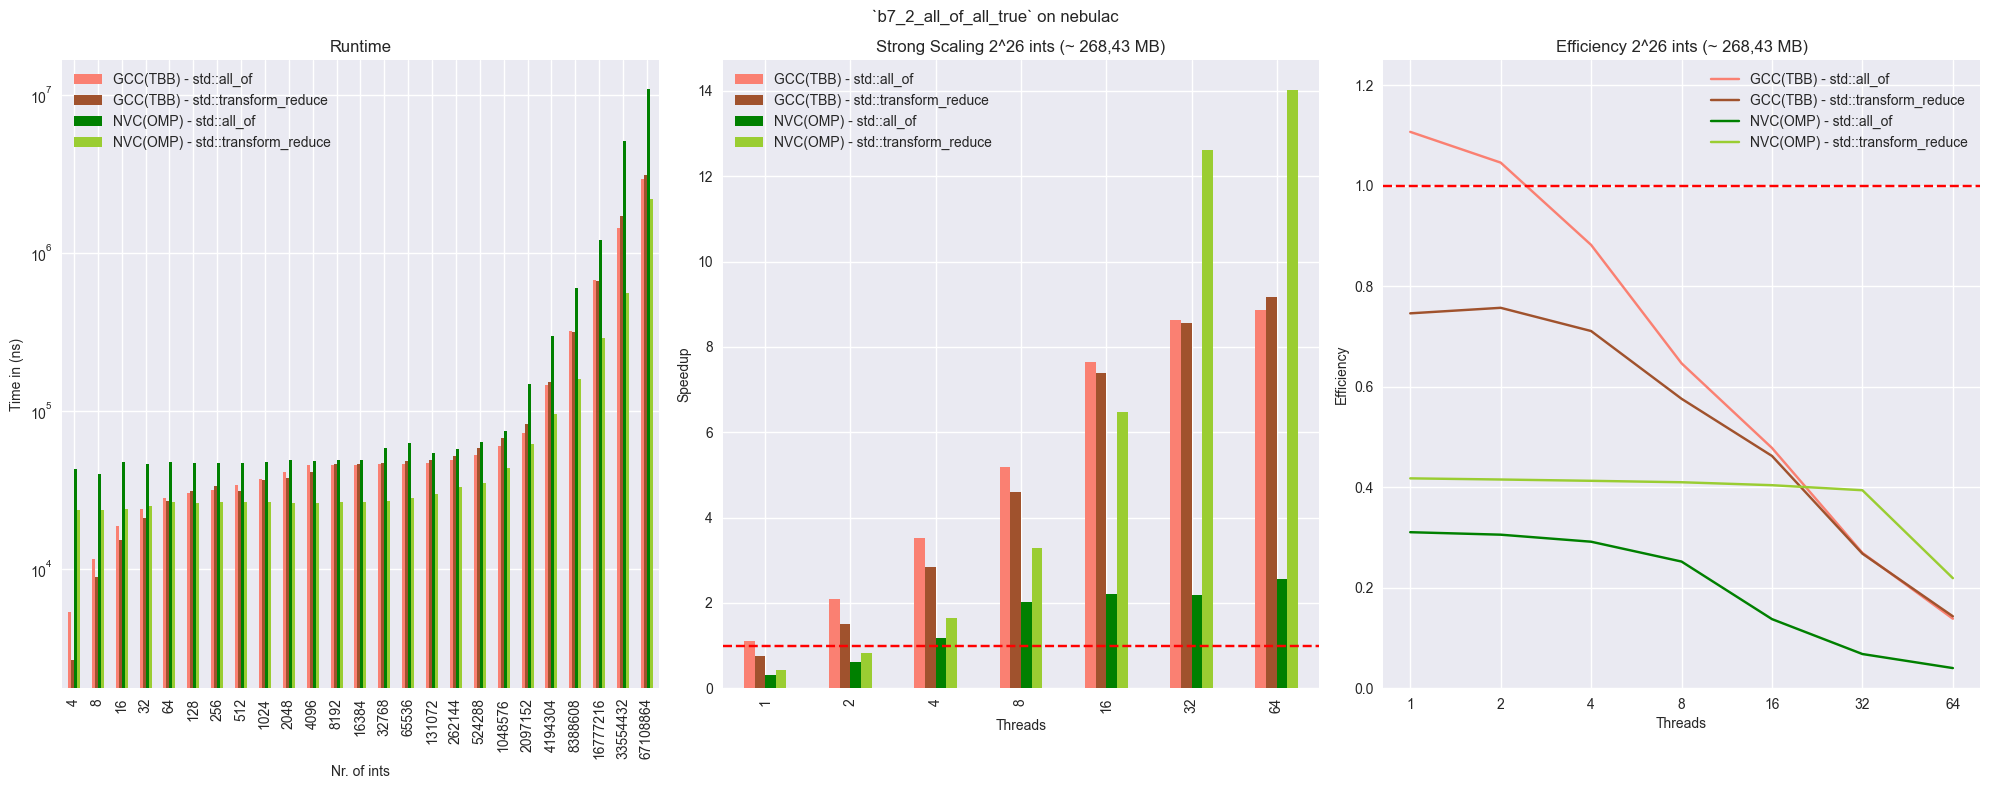

In [53]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_all_true` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_all_true` {device_name}")

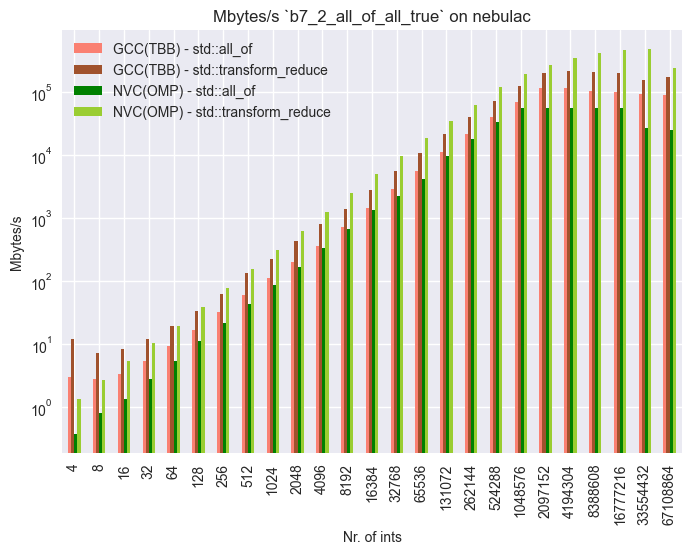

In [54]:
# mybtes graph


b7_2_all_true_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_all_true` on {device_name}')


plot(f'`b7_2_all_of_all_true` Mbytes_s on {device_name}')

## `b7_2` -  first_false

In [55]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_first_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [56]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4162.12,4,2057.2,44381.7,21669.1
1,8548.70,8,9090.3,43096.6,24287.1
2,15646.70,16,15265.5,43117.6,22284.7
3,18476.70,32,20964.2,51067.2,22464.8
4,21337.10,64,23585.7,49983.4,24426.8
5,24447.50,128,30079.5,48572.4,24529.4
6,24315.40,256,32407.7,45790.5,24397.8
7,24489.60,512,32828.7,45723.0,24405.2
8,24128.60,1024,34951.8,45634.4,24722.6
9,28211.50,2048,37924.8,45779.0,24692.2


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [57]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.046212,0.000001,0.000028,7.057563e-07
1,2,0.008810,0.000003,0.000055,1.392339e-06
2,4,0.003452,0.000005,0.000106,2.738601e-06
3,8,0.003099,0.000008,0.000191,5.307375e-06
4,16,0.002263,0.000013,0.000318,1.046504e-05
5,32,0.002251,0.000015,0.000488,1.789618e-05
6,64,0.001658,0.000015,0.000587,3.214963e-05


In [58]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.046212,1.230878e-06,0.000028,7.057563e-07
1,2,0.004405,1.253508e-06,0.000027,6.961696e-07
2,4,0.000863,1.208513e-06,0.000026,6.846503e-07
3,8,0.000387,9.940379e-07,0.000024,6.634219e-07
4,16,0.000141,8.002430e-07,0.000020,6.540650e-07
5,32,0.000070,4.548890e-07,0.000015,5.592556e-07
6,64,0.000026,2.367011e-07,0.000009,5.023379e-07


### Mbytes/s

In [59]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_first_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_bytes_merged = pd.merge(b7_2_first_false_bytes_merged,data[i], on='n')

b7_2_first_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.844200e+00,15.55510,3.605090e-01,1.47676
1,8,3.743260e+00,7.04047,7.425190e-01,2.63515
2,16,4.090320e+00,8.38492,1.484310e+00,5.74385
3,32,6.927640e+00,12.21130,2.506500e+00,11.39560
4,64,1.199790e+01,21.70800,5.121700e+00,20.96060
5,128,2.094290e+01,34.04320,1.054100e+01,41.74580
6,256,4.211330e+01,63.19480,2.236270e+01,83.94190
7,512,8.362730e+01,124.76900,4.479150e+01,167.83300
8,1024,1.697570e+02,234.38000,8.975690e+01,331.35600
9,2048,2.903780e+02,432.01300,1.789470e+02,663.53000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/1392981099.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


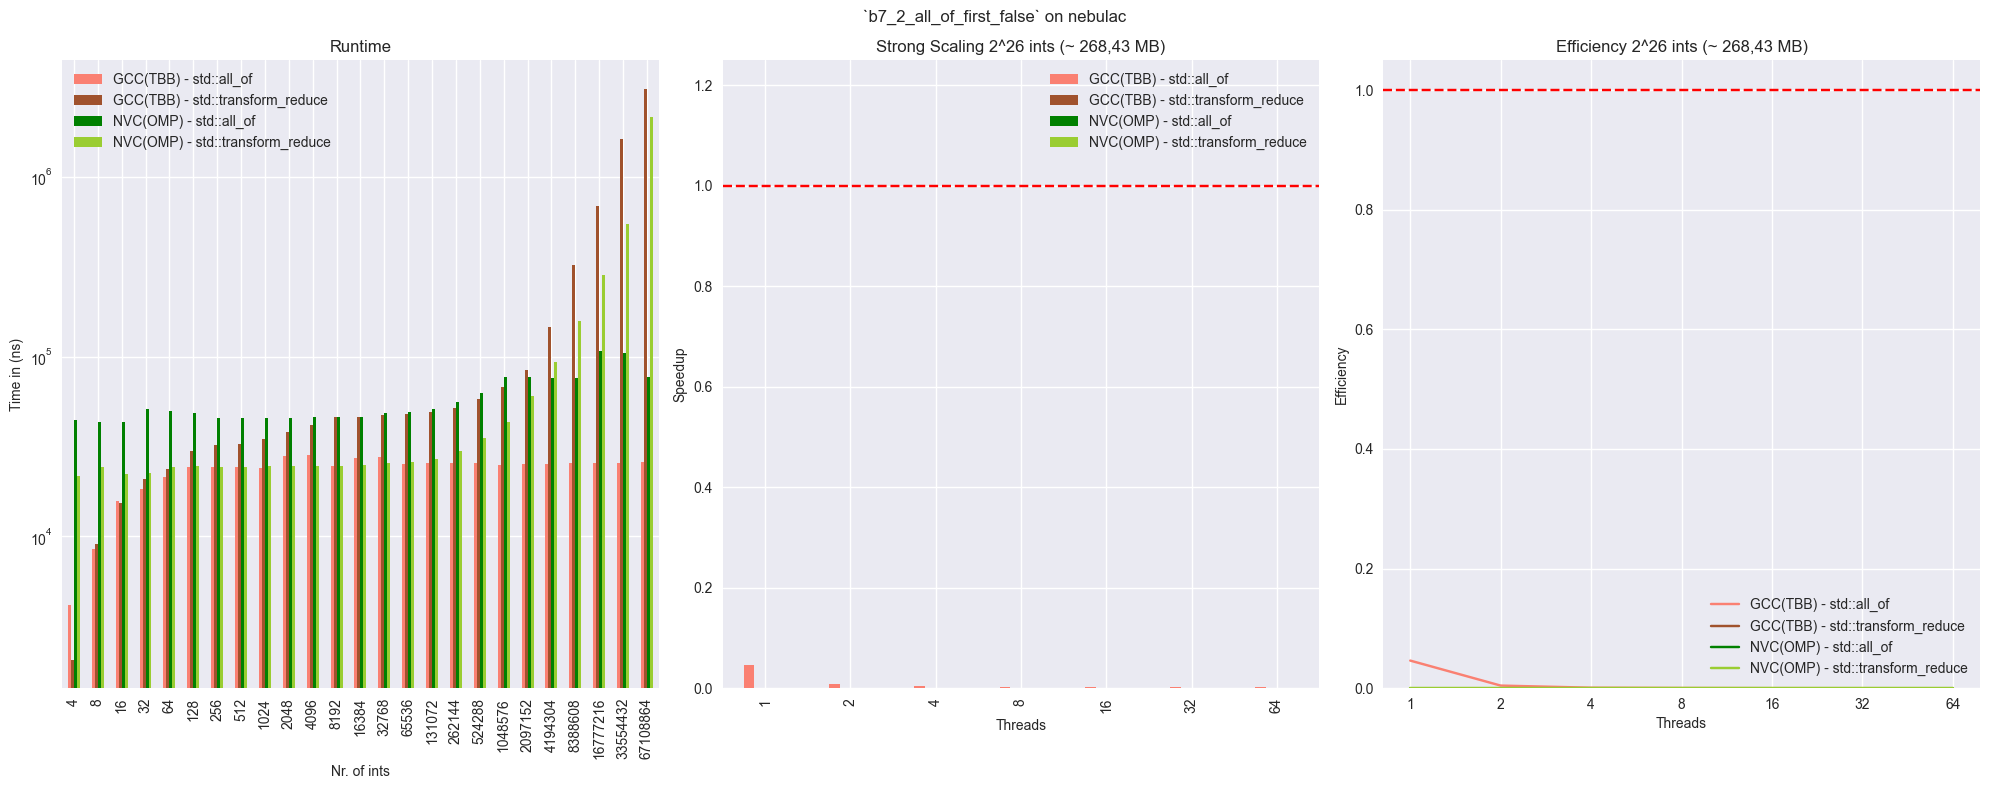

In [60]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,1.25)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_first_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_first_false` {device_name}")

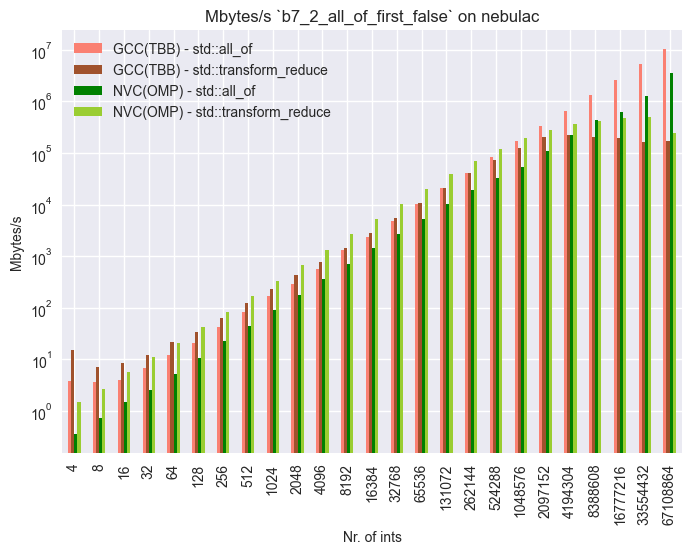

In [61]:

# mybtes graph


b7_2_first_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_first_false` on {device_name}')


plot(f'`b7_2_all_of_first_false` Mbytes_s on {device_name}')

## `b7_2` -  last_false

In [62]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

strong_scale_base = benchmark_names[0][0]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [63]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5499.61,4,2736.83,43232.9,20806.3
1,11956.60,8,5800.31,43417.5,21466.4
2,16118.70,16,11016.40,51191.1,22675.1
3,22023.90,32,16517.60,42721.2,26183.4
4,25522.70,64,21566.50,43494.0,26539.3
5,27409.50,128,25458.60,43590.1,26071.4
6,28466.90,256,27553.50,43822.5,27154.9
7,30151.60,512,30014.20,43810.6,27261.1
8,35865.30,1024,33477.60,47140.5,25130.9
9,39396.90,2048,37415.70,54401.0,24975.2


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [64]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.078959,0.699609,0.264257,0.425510
1,2,2.162888,1.416087,0.522265,0.850706
2,4,3.999977,2.787900,1.010087,1.700770
3,8,6.909990,4.894915,1.822941,3.386968
4,16,9.912567,8.254682,2.600341,6.709396
5,32,11.476587,9.752386,2.617450,12.869612
6,64,12.458576,10.397837,2.865537,21.170896


In [65]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.078959,0.699609,0.264257,0.425510
1,2,1.081444,0.708043,0.261133,0.425353
2,4,0.999994,0.696975,0.252522,0.425192
3,8,0.863749,0.611864,0.227868,0.423371
4,16,0.619535,0.515918,0.162521,0.419337
5,32,0.358643,0.304762,0.081795,0.402175
6,64,0.194665,0.162466,0.044774,0.330795


### Mbytes/s

In [66]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_last_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_bytes_merged = pd.merge(b7_2_last_false_bytes_merged,data[i], on='n')

b7_2_last_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,2.90930,11.6923,0.370088,1.53799
1,8,2.67635,11.0339,0.737030,2.98141
2,16,3.97055,11.6191,1.250220,5.64496
3,32,5.81188,15.4986,2.996170,9.77717
4,64,10.03030,23.7406,5.885860,19.29220
5,128,18.67960,40.2222,11.745800,39.27670
6,256,35.97160,74.3281,23.367000,75.41930
7,512,67.92340,136.4690,46.746600,150.25100
8,1024,114.20500,244.7010,86.889200,325.97400
9,2048,207.93500,437.8910,150.586000,656.01000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/3655766821.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


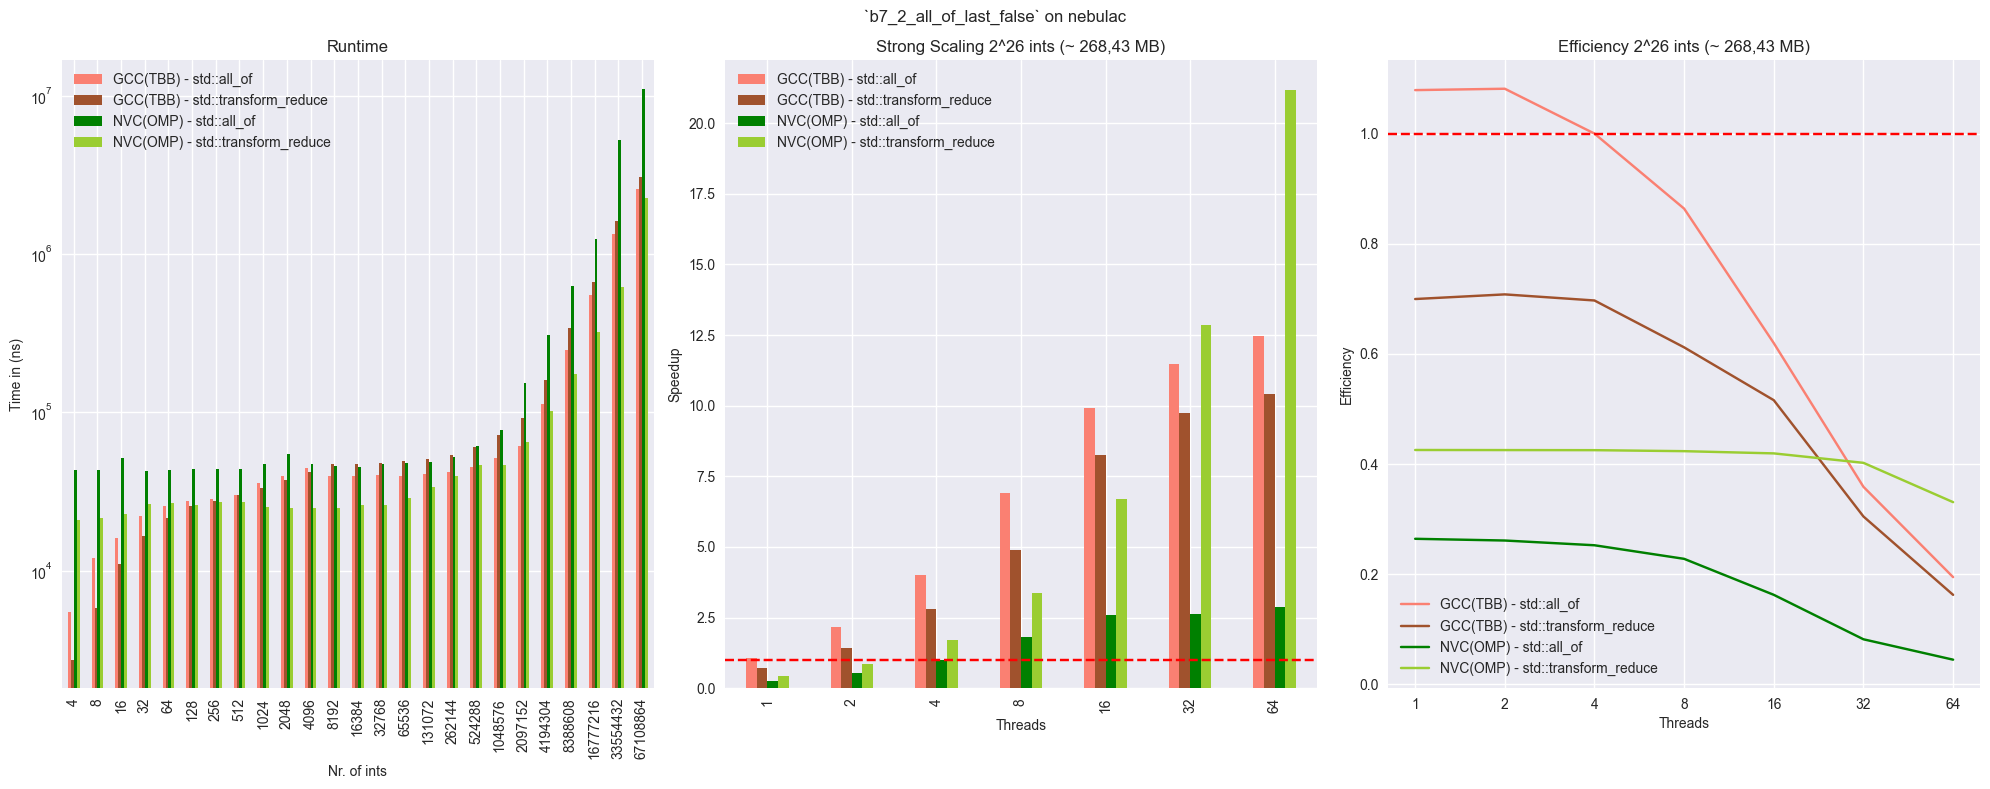

In [67]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_last_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_last_false` {device_name}")

<Axes: xlabel='threads'>

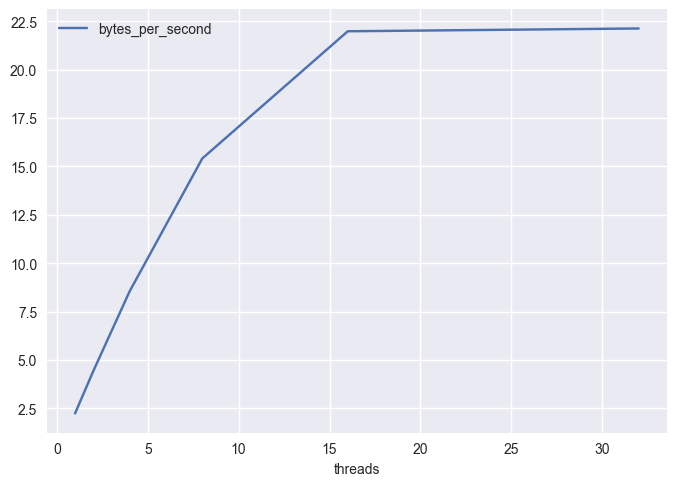

In [68]:
nvc_df = extraction_pandas_frame_algo_threaded(f'{root_dir}/NVHPC_Multicore/THREADS',
                                               f'b7_2_all_of_last_false_par',
                                               [1,2,4,8,16,32],
                                               COMP='NVC',
                                               include_bytes=True
)

nvc_df['bytes_per_second'] = nvc_df['bytes_per_second'] / 1_000_000_000
nvc_df.plot(x='threads',y='bytes_per_second')

Text(0.5, 1.0, 'b7_2_all_of_last_false \n2^26 ints (~ 268,43 MB)')

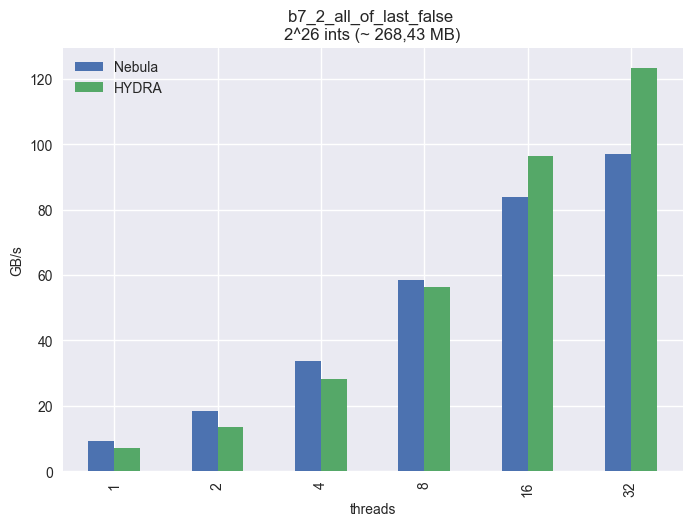

In [69]:
gcc_df = extraction_pandas_frame_algo_threaded(f'{root_dir}/GCC_TBB/THREADS',
                                               f'b7_2_all_of_last_false_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)






gcc_hydra_df = extraction_pandas_frame_algo_threaded(f'/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/GCC_TBB/THREADS',
                                               f'b7_2_all_of_last_false_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)




gcc_df['bytes_per_second'] = (gcc_df['bytes_per_second'] / 1_000_000_000)
gcc_hydra_df['bytes_per_second'] = (gcc_hydra_df['bytes_per_second'] / 1_000_000_000) 


gcc_df = gcc_df.rename(columns={'bytes_per_second': 'Nebula'})
gcc_hydra_df = gcc_hydra_df.rename(columns={'bytes_per_second': 'HYDRA'})


xx = pd.merge(gcc_df,gcc_hydra_df,on='threads')

xx = xx.drop(['name_x','real_time_x','cpu_time_x','time_unit_x',	'n_x'	,'median_x'	,'stddev_x'	,'Compiler_x',	'name_y'	,'real_time_y'	,'cpu_time_y',	'time_unit_y',	'n_y',	'median_y',	'stddev_y',	'Compiler_y'],axis=1)

ax = xx.plot(kind='bar',x='threads')
ax.set_ylabel('GB/s')
ax.set_title('b7_2_all_of_last_false \n2^26 ints (~ 268,43 MB)')


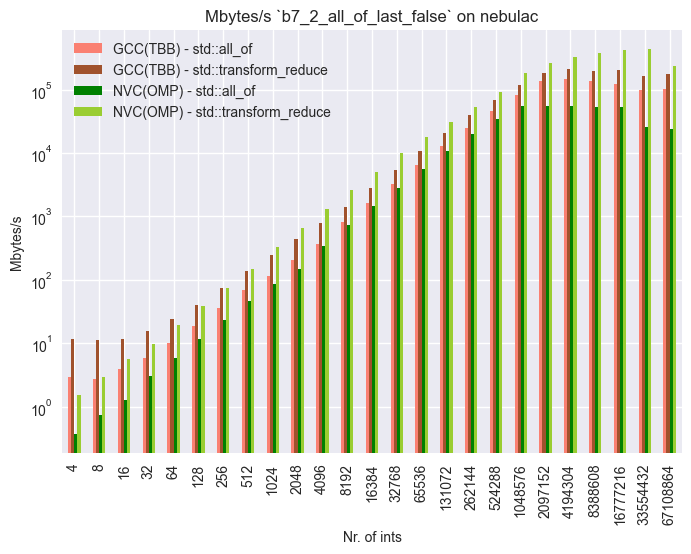

In [70]:
b7_2_last_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_last_false` on {device_name}')


plot(f'`b7_2_all_of_last_false` Mbytes_s on {device_name}')

## `b7_2` -  auto_false

In [71]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_auto_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [72]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5265.04,4,2400.38,42544.9,20254.2
1,10874.30,8,6677.63,46948.4,20567.5
2,17330.90,16,11603.50,47951.2,21725.5
3,20725.10,32,16896.30,46794.0,23170.7
4,24161.30,64,27322.40,46563.6,22717.9
5,26809.40,128,30020.90,46724.2,22529.3
6,29544.30,256,32696.30,44723.3,22697.5
7,29434.30,512,34267.80,44000.3,24542.7
8,29453.10,1024,35818.10,44346.6,24188.7
9,28538.90,2048,37944.10,46940.5,23771.9


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [73]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.044155,0.000005,0.000121,0.039989
1,2,0.011867,0.000010,0.000223,0.008431
2,4,0.003967,0.000020,0.000401,0.004544
3,8,0.003142,0.000038,0.000552,0.002407
4,16,0.002531,0.000071,0.000718,0.002079
5,32,0.002235,0.000127,0.000827,0.001960
6,64,0.002038,0.000207,0.000974,0.001794


In [74]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.044155,0.000005,0.000121,0.039989
1,2,0.005934,0.000005,0.000112,0.004216
2,4,0.000992,0.000005,0.000100,0.001136
3,8,0.000393,0.000005,0.000069,0.000301
4,16,0.000158,0.000004,0.000045,0.000130
5,32,0.000070,0.000004,0.000026,0.000061
6,64,0.000032,0.000003,0.000015,0.000028


### Mbytes/s

In [75]:
# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_auto_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_bytes_merged = pd.merge(b7_2_auto_false_bytes_merged,data[i], on='n')

b7_2_auto_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.038910e+00,1.333120e+01,3.760730e-01,1.579920e+00
1,8,2.942710e+00,9.584230e+00,6.815990e-01,3.111700e+00
2,16,3.692830e+00,1.103120e+01,1.334690e+00,5.891700e+00
3,32,6.176090e+00,1.515120e+01,2.735390e+00,1.104840e+01
4,64,1.059550e+01,1.873920e+01,5.497850e+00,2.253730e+01
5,128,1.909770e+01,3.410950e+01,1.095790e+01,4.545190e+01
6,256,3.465980e+01,6.263710e+01,2.289640e+01,9.023040e+01
7,512,6.957880e+01,1.195290e+02,4.654510e+01,1.668930e+02
8,1024,1.390690e+02,2.287110e+02,9.236340e+01,3.386700e+02
9,2048,2.870470e+02,4.317930e+02,1.745190e+02,6.892180e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/1629545763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


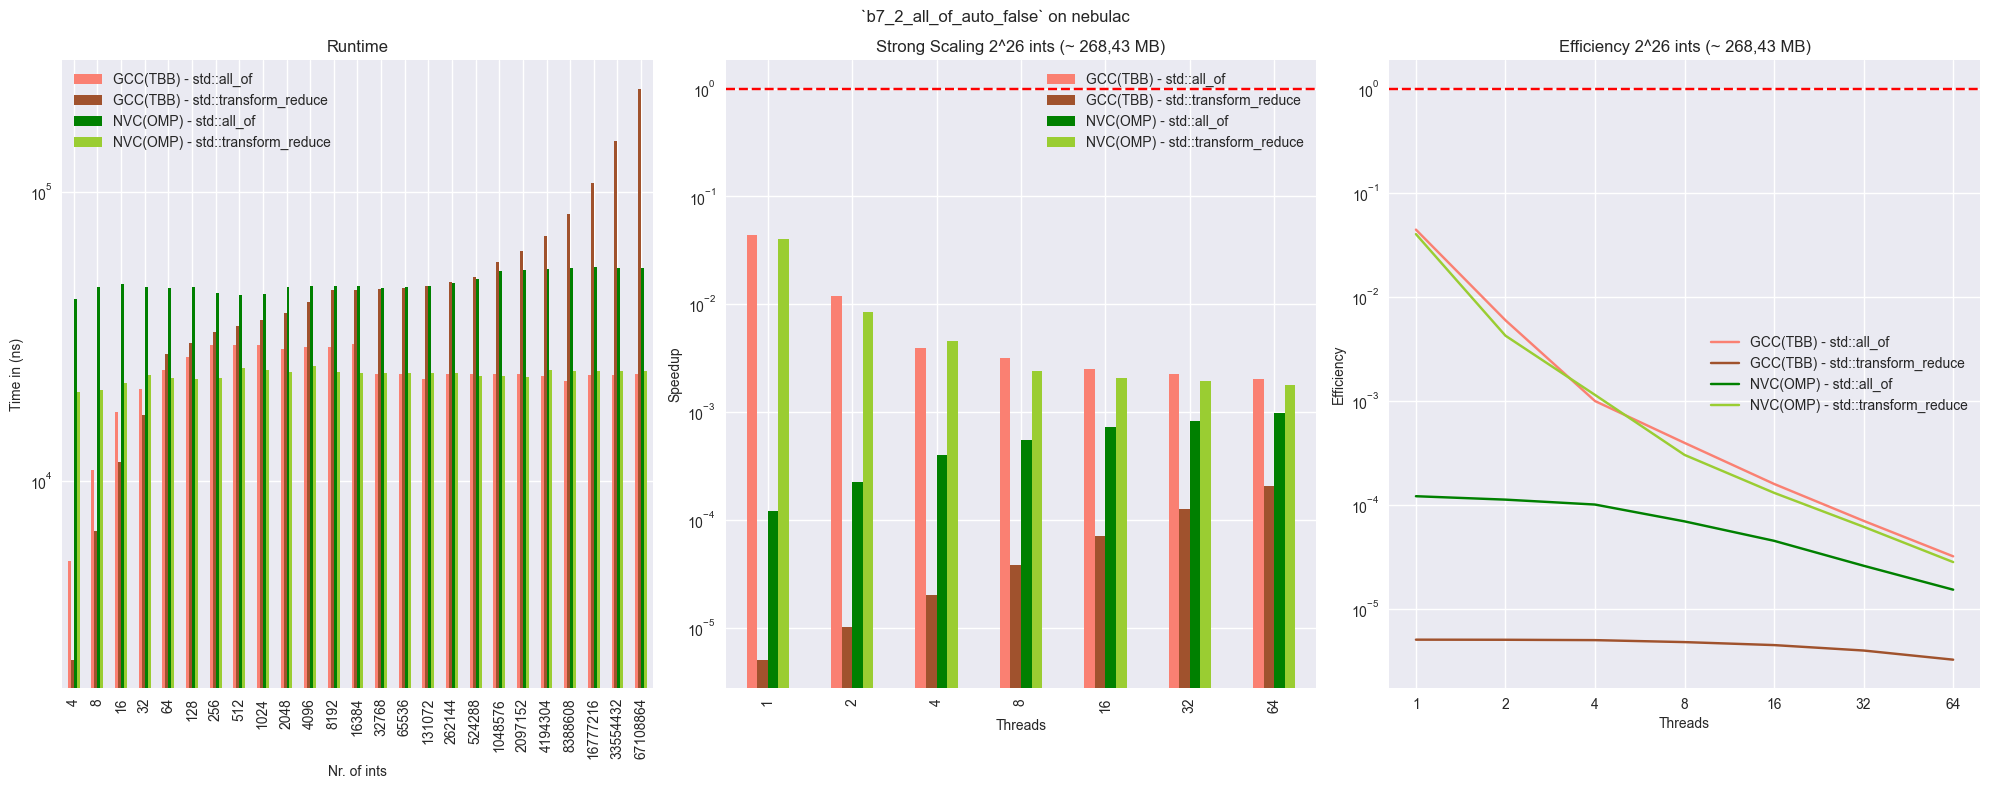

In [76]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_auto_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_auto_false` {device_name}")

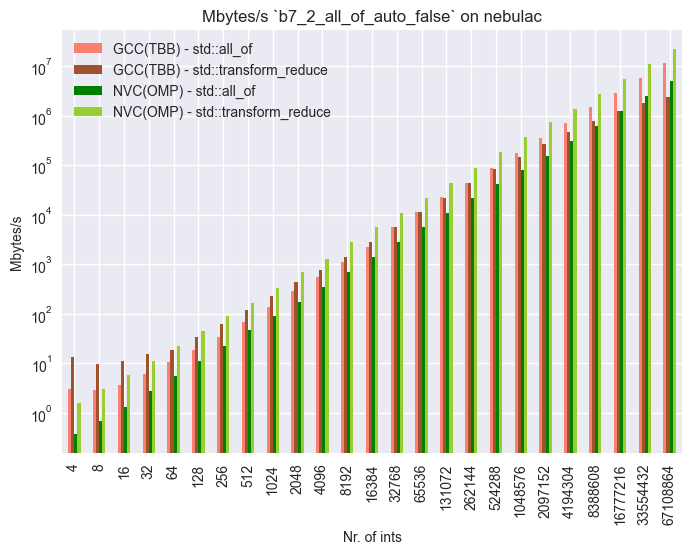

In [77]:

# mybtes graph

b7_2_auto_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_auto_false` on {device_name}')


plot(f'`b7_2_all_of_auto_false` Mbytes_s on {device_name}')

## `b7_3` -  all_hit

In [78]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_all_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [79]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6521.39,4,3613.01,21514.4,22194.7
1,15893.70,8,6710.48,22438.0,21937.1
2,22402.60,16,11963.60,22956.0,21959.6
3,28006.30,32,17283.10,22952.9,23161.5
4,32378.70,64,26129.70,23552.9,24124.5
5,34251.40,128,30136.40,21912.6,24087.0
6,35771.50,256,32144.10,22277.2,23662.8
7,37199.10,512,32802.70,22531.7,23687.4
8,39855.70,1024,34378.70,22513.1,23717.5
9,43250.90,2048,36609.20,22965.8,23797.9


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [80]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.057070,0.491957,0.901532,1.468296
1,2,2.027193,0.993669,1.804461,2.903182
2,4,3.273672,1.958983,3.597039,5.806438
3,8,4.118461,3.553168,7.027283,9.996491
4,16,6.523667,5.998575,13.667926,19.852268
5,32,7.151678,7.789834,12.522850,12.473497
6,64,7.559028,7.459901,17.747037,22.162232


In [81]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.057070,0.491957,0.901532,1.468296
1,2,1.013596,0.496835,0.902230,1.451591
2,4,0.818418,0.489746,0.899260,1.451609
3,8,0.514808,0.444146,0.878410,1.249561
4,16,0.407729,0.374911,0.854245,1.240767
5,32,0.223490,0.243432,0.391339,0.389797
6,64,0.118110,0.116561,0.277297,0.346285


### Mbytes/s

In [82]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_all_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_bytes_merged = pd.merge(b7_3_all_hit_bytes_merged,data[i], on='n')

b7_3_all_hit_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,2.45346,4.42844,0.743688,7.208910e-01
1,8,2.01338,4.76866,1.426150,1.458720e+00
2,16,2.85681,5.34955,2.787940,2.914450e+00
3,32,4.57040,7.40607,5.576630,5.526410e+00
4,64,7.90644,9.79730,10.869200,1.061160e+01
5,128,14.94830,16.98940,23.365600,2.125630e+01
6,256,28.62610,31.85660,45.966300,4.327470e+01
7,512,55.05510,62.43380,90.894300,8.645950e+01
8,1024,102.77100,119.14300,181.939000,1.727000e+02
9,2048,189.40600,223.76900,356.705000,3.442320e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/3164471847.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


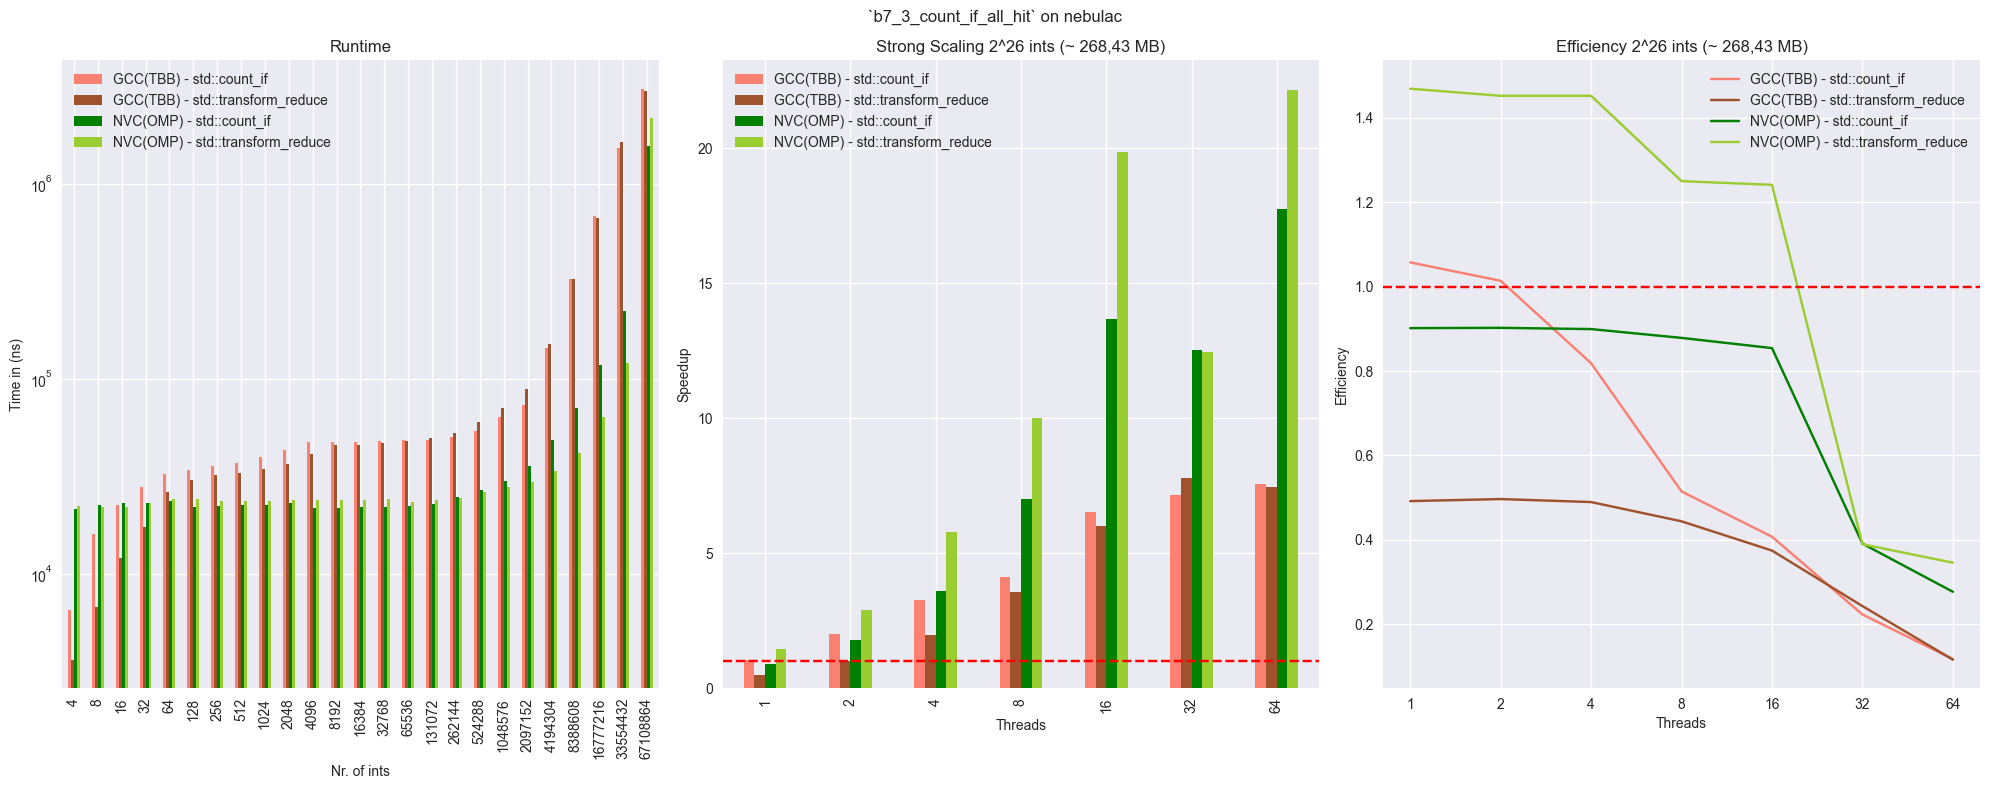

In [83]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle(f"`b7_3_count_if_all_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_all_hit` {device_name}")

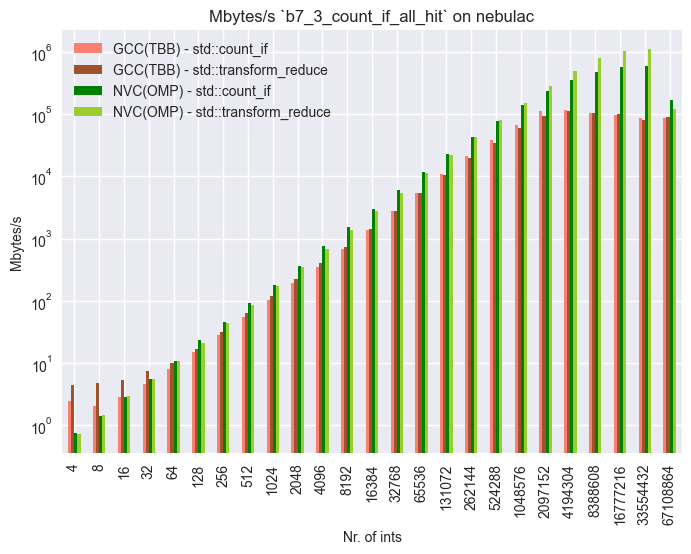

In [84]:
# mybtes graph

b7_3_all_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_all_hit` on {device_name}')


plot(f'`b7_3_count_if_all_hit` Mbytes_s on {device_name}')

## `b7_3` -  half_hit

In [85]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_half_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [86]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6369.91,4,3032.07,20949.2,22093.4
1,13030.20,8,9436.39,20632.9,22005.6
2,19243.40,16,15663.20,21732.7,22496.1
3,24256.30,32,20160.40,21912.2,24253.7
4,28039.10,64,25015.60,23908.5,24009.3
5,29708.00,128,27302.70,23071.3,24258.3
6,32390.40,256,28332.20,23885.8,24321.8
7,36165.80,512,30411.00,25650.8,24341.3
8,40541.10,1024,34626.60,28955.7,24431.6
9,45422.70,2048,37366.00,24258.8,24420.3


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [87]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.997098,0.462800,0.791449,1.358870
1,2,1.878184,0.934855,1.592929,2.387005
2,4,3.026608,1.837270,3.146118,5.306210
3,8,4.711339,3.520494,6.125027,8.850618
4,16,5.991189,5.616327,11.823438,14.794681
5,32,6.683963,6.602560,12.450126,12.677528
6,64,7.053245,7.071964,13.044471,12.540202


In [88]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.997098,0.462800,0.791449,1.358870
1,2,0.939092,0.467428,0.796465,1.193503
2,4,0.756652,0.459317,0.786530,1.326553
3,8,0.588917,0.440062,0.765628,1.106327
4,16,0.374449,0.351020,0.738965,0.924668
5,32,0.208874,0.206330,0.389066,0.396173
6,64,0.110207,0.110499,0.203820,0.195941


### Mybtes/s

In [89]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_half_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_bytes_merged = pd.merge(b7_3_half_hit_bytes_merged,data[i], on='n')

b7_3_half_hit_bytes_merged


,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,2.51181,5.27692,0.763753,7.241990e-01
1,8,2.45584,3.39113,1.550920,1.454180e+00
2,16,3.32581,4.08600,2.944870,2.844940e+00
3,32,5.27698,6.34908,5.841490,5.277550e+00
4,64,9.13012,10.23360,10.707500,1.066250e+01
5,128,17.23440,18.75270,22.192100,2.110620e+01
6,256,31.61430,36.14260,42.870700,4.210220e+01
7,512,56.62810,67.34400,79.841700,8.413670e+01
8,1024,101.03300,118.29100,141.458000,1.676520e+02
9,2048,180.35000,219.23600,337.691000,3.354590e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/4180608575.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


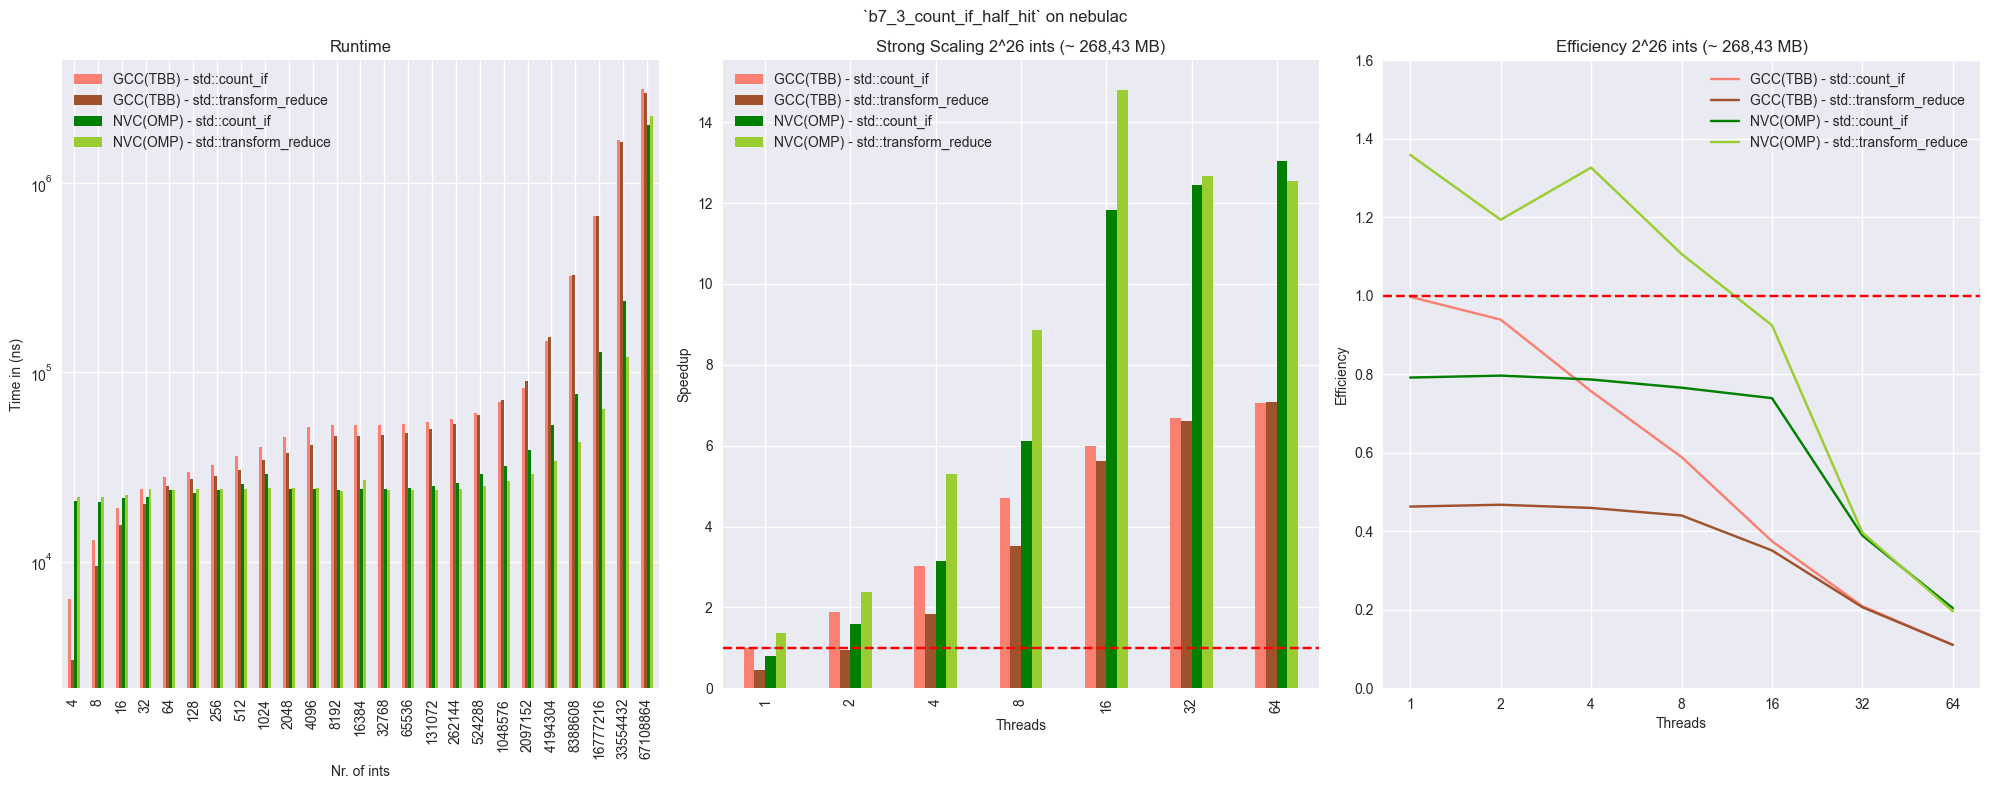

In [90]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')
ax_3.set_ylim(0,1.6)


fig.suptitle(f"`b7_3_count_if_half_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_half_hit` {device_name}")

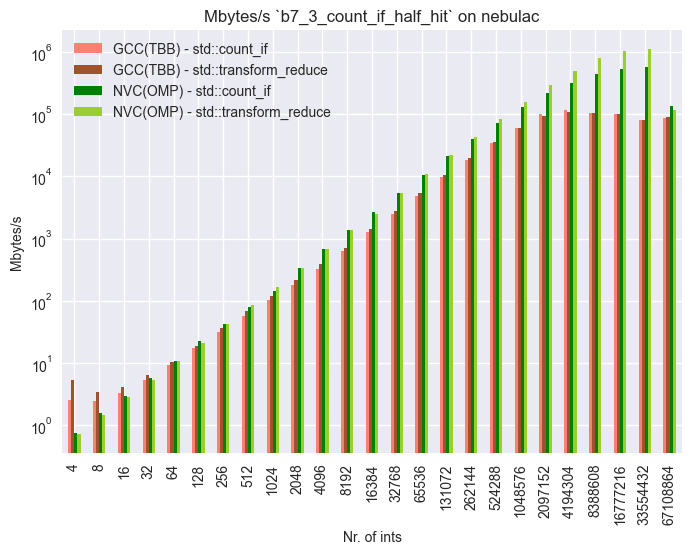

In [91]:
# mybtes graph

b7_3_half_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_half_hit` Mbytes_s on {device_name}')

## `b7_3` -  orders_struct

In [92]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_orders_struct'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [93]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6281.65,4,2980.73,21464.1,22326.8
1,11728.60,8,5728.40,21862.9,22737.9
2,17290.20,16,10555.20,22292.8,23092.6
3,22375.10,32,15844.60,22434.7,22486.7
4,26530.10,64,20982.30,22651.3,22298.0
5,28738.50,128,25078.20,22070.1,22150.5
6,31043.30,256,27573.90,21772.7,22170.2
7,34392.20,512,29695.70,21731.5,23264.5
8,39589.00,1024,32637.00,23547.2,23315.6
9,43467.00,2048,36442.50,24971.6,23672.7


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [94]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.996970,0.552120,0.992965,1.058372
1,2,1.938687,1.118480,1.925087,2.091702
2,4,2.820479,2.143203,3.943781,4.212704
3,8,3.811152,3.469345,7.620069,8.289770
4,16,5.824019,5.514004,15.096165,16.052178
5,32,6.278611,6.368186,20.699045,19.173264
6,64,6.666720,6.762846,19.349669,16.083949


In [95]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.996970,0.552120,0.992965,1.058372
1,2,0.969343,0.559240,0.962544,1.045851
2,4,0.705120,0.535801,0.985945,1.053176
3,8,0.476394,0.433668,0.952509,1.036221
4,16,0.364001,0.344625,0.943510,1.003261
5,32,0.196207,0.199006,0.646845,0.599164
6,64,0.104167,0.105669,0.302339,0.251312


### Mbytes/s

In [96]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_orders_struct_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_bytes_merged = pd.merge(b7_3_orders_struct_bytes_merged,data[i], on='n')

b7_3_orders_struct_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,5.09421,10.7356,1.49086,1.43326
1,8,5.45674,11.1724,2.92733,2.81469
2,16,7.40303,12.1267,5.74177,5.54290
3,32,11.44130,16.1569,11.41090,11.38450
4,64,19.29890,24.4016,22.60360,22.96170
5,128,35.63160,40.8322,46.39760,46.22930
6,256,65.97240,74.2731,94.06280,92.37610
7,512,119.09700,137.9330,188.48200,176.06200
8,1024,206.92600,251.0030,347.89700,351.35200
9,2048,376.93000,449.5850,656.10500,692.10600


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/2492568009.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


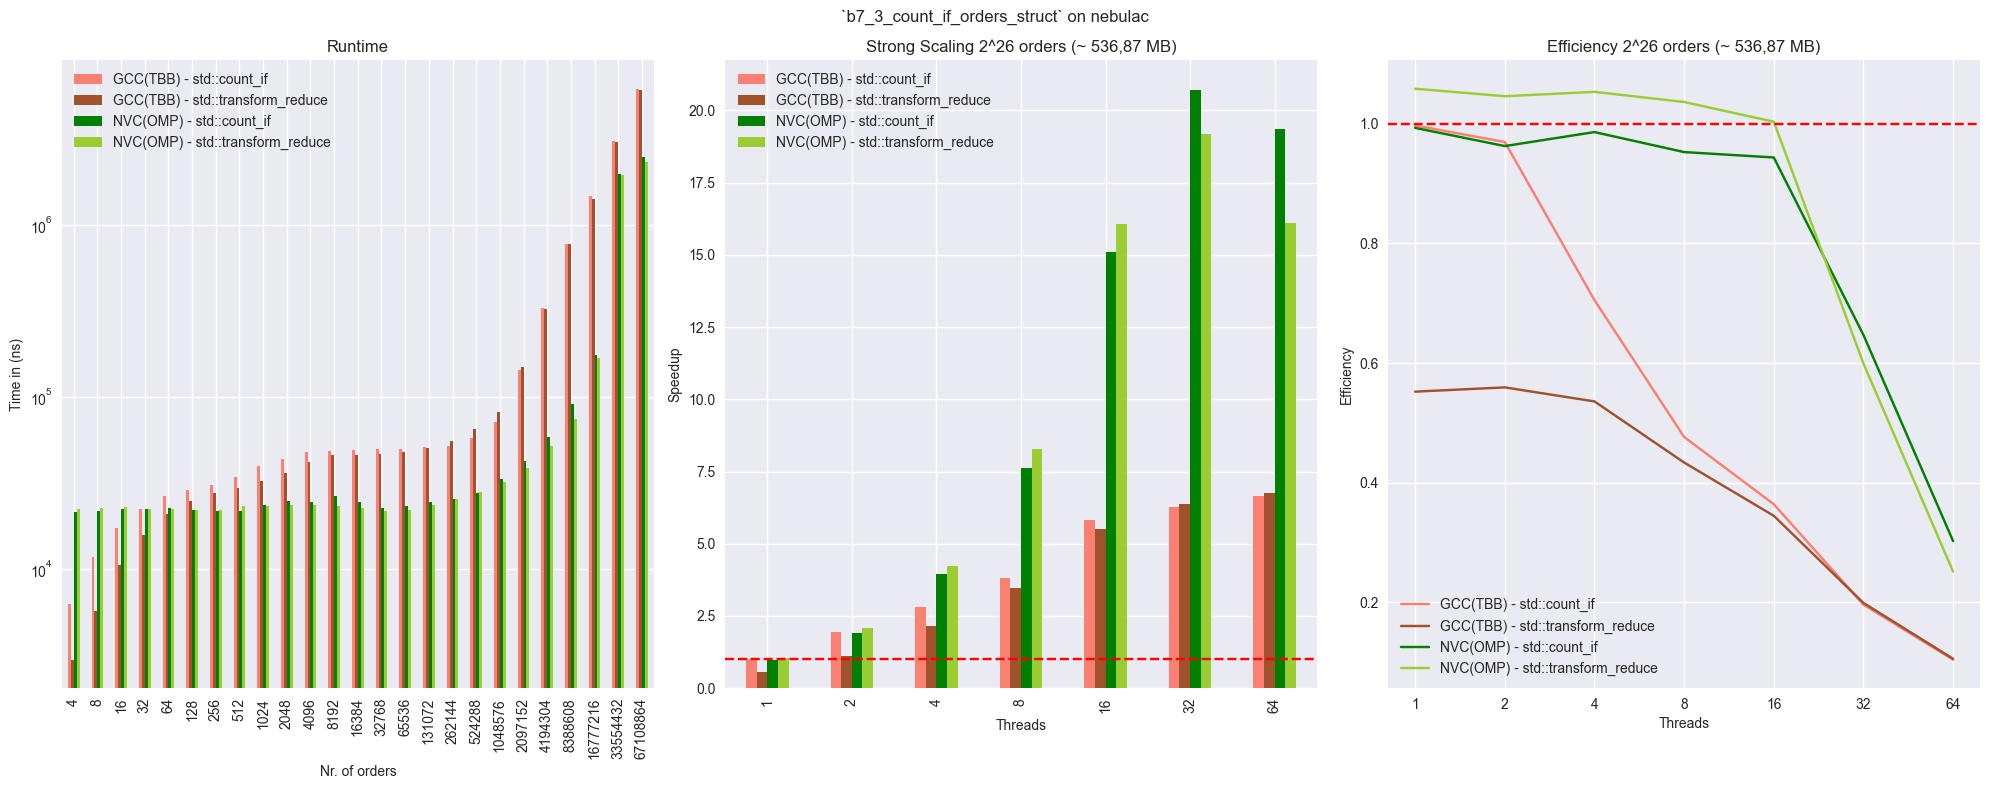

In [97]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of orders')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 orders (~ 536,87 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 orders (~ 536,87 MB)')


fig.suptitle(f"`b7_3_count_if_orders_struct` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_orders_struct` {device_name}")

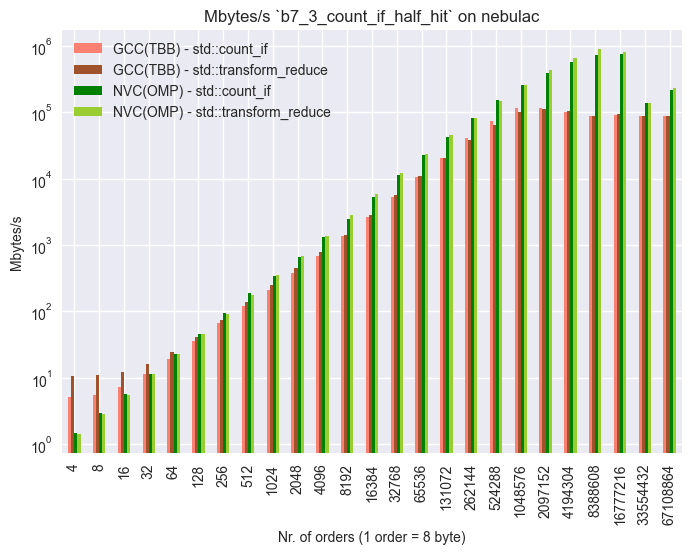

In [98]:
# mybtes graph

b7_3_orders_struct_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of orders (1 order = 8 byte)')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_orders_struct` Mbytes_s on {device_name}')

## `b7_4` - stencil transform 

In [99]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

strong_scale_base = benchmark_names[1][0]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [100]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,3042.00,4,3617.49,12164.8,11103.8
1,9196.59,8,13436.70,13430.9,9840.4
2,16669.20,16,18716.10,12848.5,10077.1
3,24340.10,32,26904.20,13134.6,10435.7
4,27778.80,64,26920.80,13308.1,11642.2
5,29125.50,128,27872.80,13156.6,10978.8
6,31307.20,256,30775.00,12591.6,10979.7
7,34482.50,512,34242.90,13151.6,11811.3
8,38499.60,1024,38284.50,12139.9,12070.7
9,43275.80,2048,43534.80,12136.6,10667.2


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [101]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of='b7_4_stencil_for_each_to_neightbours_stdev'
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.754202,0.708940,1.042950,0.537814
1,2,1.507647,1.416086,2.084086,1.065684
2,4,3.015365,2.827419,4.167476,2.144489
3,8,6.009184,5.638461,8.322942,4.235692
4,16,11.957097,11.246853,16.625744,8.295763
5,32,19.581195,19.277485,32.203604,16.288609
6,64,20.612229,20.582446,50.978184,32.889753


In [102]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.754202,0.708940,1.042950,0.537814
1,2,0.753824,0.708043,1.042043,0.532842
2,4,0.753841,0.706855,1.041869,0.536122
3,8,0.751148,0.704808,1.040368,0.529462
4,16,0.747319,0.702928,1.039109,0.518485
5,32,0.611912,0.602421,1.006363,0.509019
6,64,0.322066,0.321601,0.796534,0.513902


### Mbytes/s

In [103]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_4_stencil_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_bytes_merged = pd.merge(b7_4_stencil_bytes_merged,data[i], on='n')

b7_4_stencil_bytes_merged


,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,19.7238,16.58610,4.93228,5.40355
1,8,13.4833,9.22848,9.23242,12.60110
2,16,15.1177,13.46430,19.61320,25.00720
3,32,20.8709,18.88180,38.67650,48.67920
4,64,36.7186,37.88890,76.64480,87.61210
5,128,70.1790,73.33330,155.35900,186.17600
6,256,130.7050,132.96500,324.97900,372.68700
7,512,237.4540,239.11500,622.58400,693.23400
8,1024,425.4590,427.84900,1349.27000,1357.01000
9,2048,757.0970,752.59400,2699.60000,3071.47000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/1698835649.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


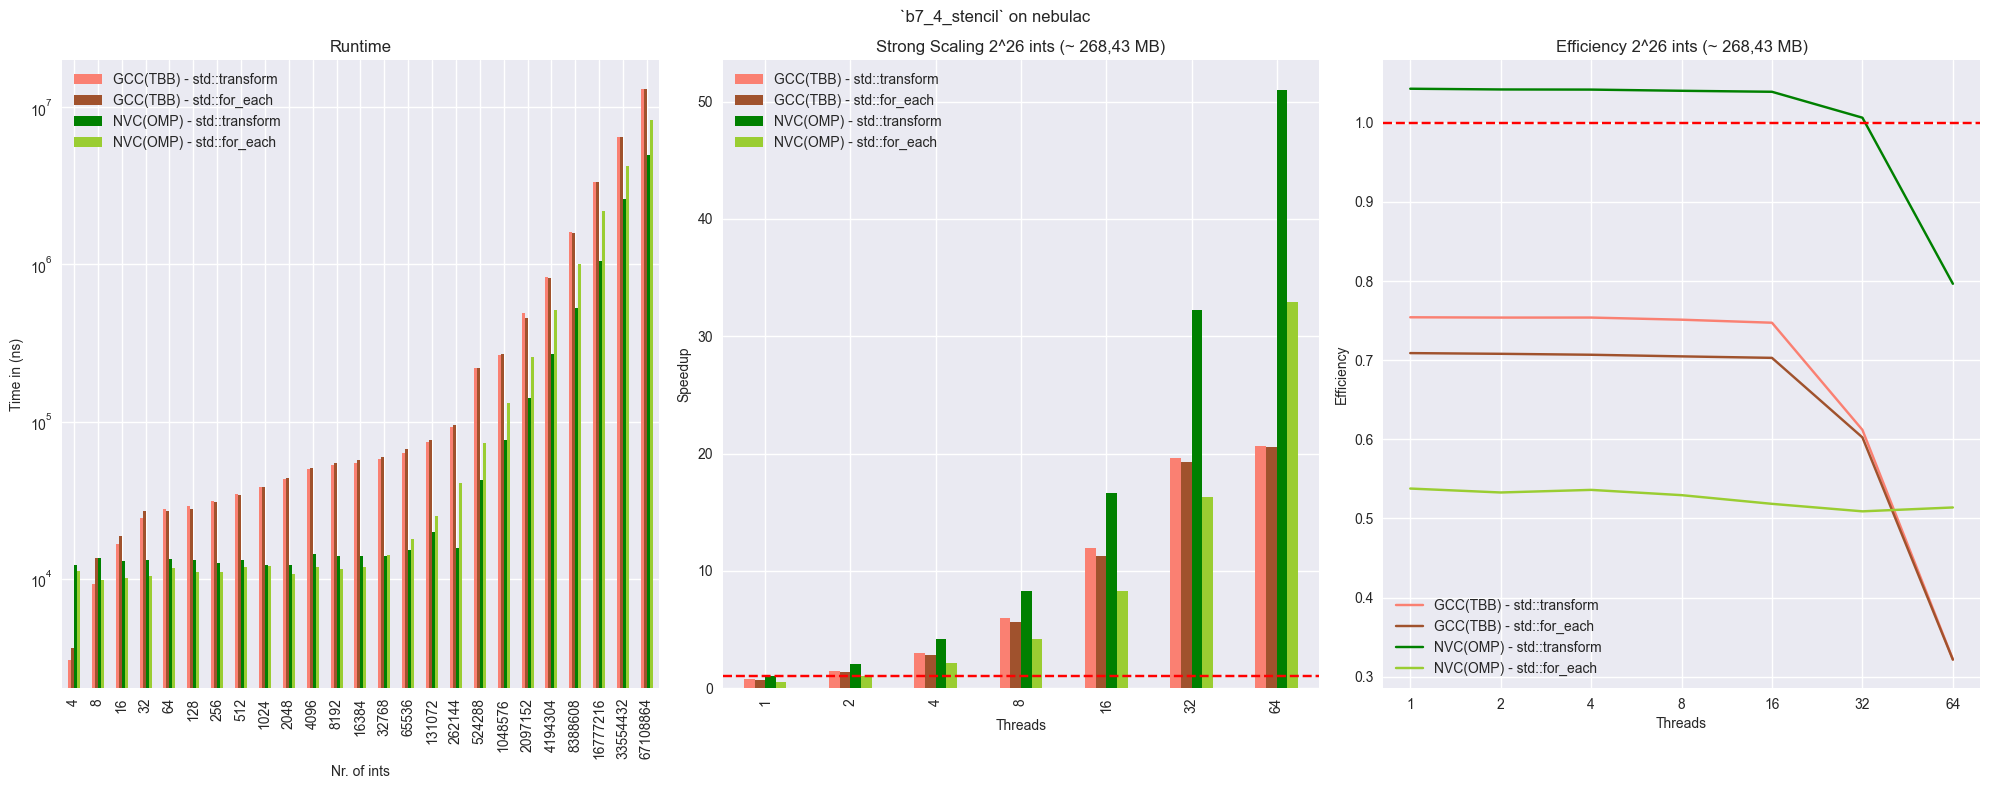

In [104]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

#ax_2.set_ylim(0,2.5)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_4_stencil` on {device_name}")

fig.tight_layout()

plot(f"`b7_4_stencil` {device_name}")

In [105]:
nv_test = extraction_pandas_frame_algo(root_dir+'/NVHPC_Multicore/DEFAULT/b7_4_stencil_transform_number_to_neightbours_stdev_seq__Default.csv',include_bytes_per_second=True)
nv_test['bytes_per_second'] = int(nv_test['bytes_per_second'])

nv_test

,name,real_time,cpu_time,time_unit,bytes_per_second,n,median,stddev,Compiler
0,NVHPC_Multicore_b7_4_stencil_transform_number_...,60573600.0,60592000.0,ns,17726200000,67108864,60594300.0,10135.3,COMP


In [106]:
gcc_test = extraction_pandas_frame_algo(root_dir+'/GCC_TBB/DEFAULT/b7_4_stencil_transform_number_to_neightbours_stdev_seq__Default.csv',include_bytes_per_second=True)
gcc_test['bytes_per_second'] = int(gcc_test['bytes_per_second'])

gcc_test

,name,real_time,cpu_time,time_unit,bytes_per_second,n,median,stddev,Compiler
0,GCC_TBB_b7_4_stencil_transform_number_to_neigh...,363437000.0,363717000.0,ns,2954410000,67108864,363746000.0,168940.0,COMP


In [107]:
gcc_test['bytes_per_second']- nv_test['bytes_per_second']
# nv has better performance on hydra

0   -14771790000
Name: bytes_per_second, dtype: int64

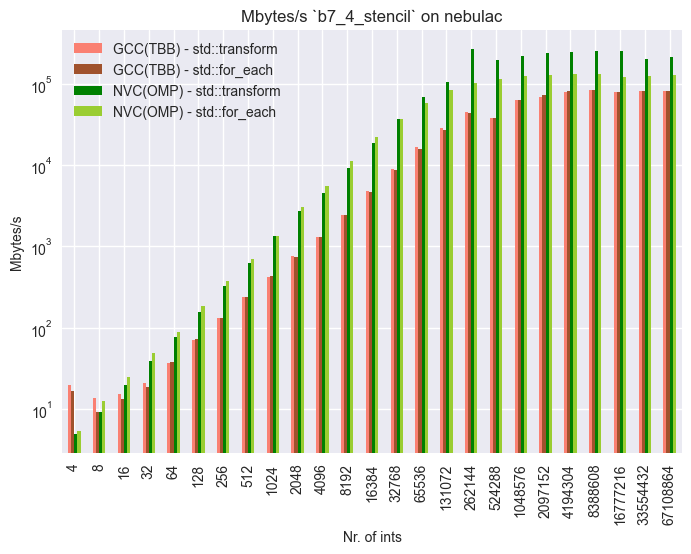

In [108]:

# mbytes graph

b7_4_stencil_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_4_stencil` on {device_name}')


plot(f'`b7_4_stencil` Mbytes_s on {device_name}')

## `b7_5` - Scalar Transform 

In [109]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

strong_scale_base = 'b7_5_scalar_transform_number'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [110]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,7008.72,4,4930.82,12131.80,10904.0
1,13829.70,8,14762.00,9581.55,10634.7
2,19535.50,16,21213.20,9818.23,10635.0
3,24363.60,32,26201.50,10826.30,11255.9
4,27435.50,64,28201.40,15461.40,13405.1
5,32259.80,128,31418.70,12880.00,12843.0
6,33488.20,256,33049.50,10930.40,11880.2
7,35944.00,512,35003.60,10375.50,11223.0
8,38369.60,1024,38173.80,10138.50,11218.2
9,42975.10,2048,43385.50,10453.00,11327.1


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [111]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.006230,0.344648,0.114256,0.057496
1,2,1.336136,0.618708,0.228472,0.118593
2,4,3.097551,1.202650,0.456078,0.236941
3,8,3.693207,2.127095,0.912301,0.473487
4,16,4.471024,3.085333,1.822310,0.850259
5,32,4.716683,3.481038,3.624175,1.883839
6,64,4.944775,3.575703,7.213986,3.751025


In [112]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.006230,0.344648,0.114256,0.057496
1,2,0.668068,0.309354,0.114236,0.059297
2,4,0.774388,0.300662,0.114019,0.059235
3,8,0.461651,0.265887,0.114038,0.059186
4,16,0.279439,0.192833,0.113894,0.053141
5,32,0.147396,0.108782,0.113255,0.058870
6,64,0.077262,0.055870,0.112719,0.058610


### Mbytes/s

In [113]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_5_scalar_transform_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_bytes_merged = pd.merge(b7_5_scalar_transform_bytes_merged,data[i], on='n')

b7_5_scalar_transform_bytes_merged

,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,4.56574,6.48979,2.63769,2.93470
1,8,4.62772,4.33545,6.67951,6.01805
2,16,6.55219,6.03398,13.03700,12.03570
3,32,10.50750,9.77043,23.64610,22.74370
4,64,18.66190,18.15520,33.11470,38.19430
5,128,31.74230,32.59200,79.50330,79.73200
6,256,61.15580,61.96770,187.36700,172.38800
7,512,113.95500,117.01700,394.77600,364.96600
8,1024,213.50200,214.59800,808.01100,730.24000
9,2048,381.24400,377.63800,1567.40000,1446.44000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/3247401511.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


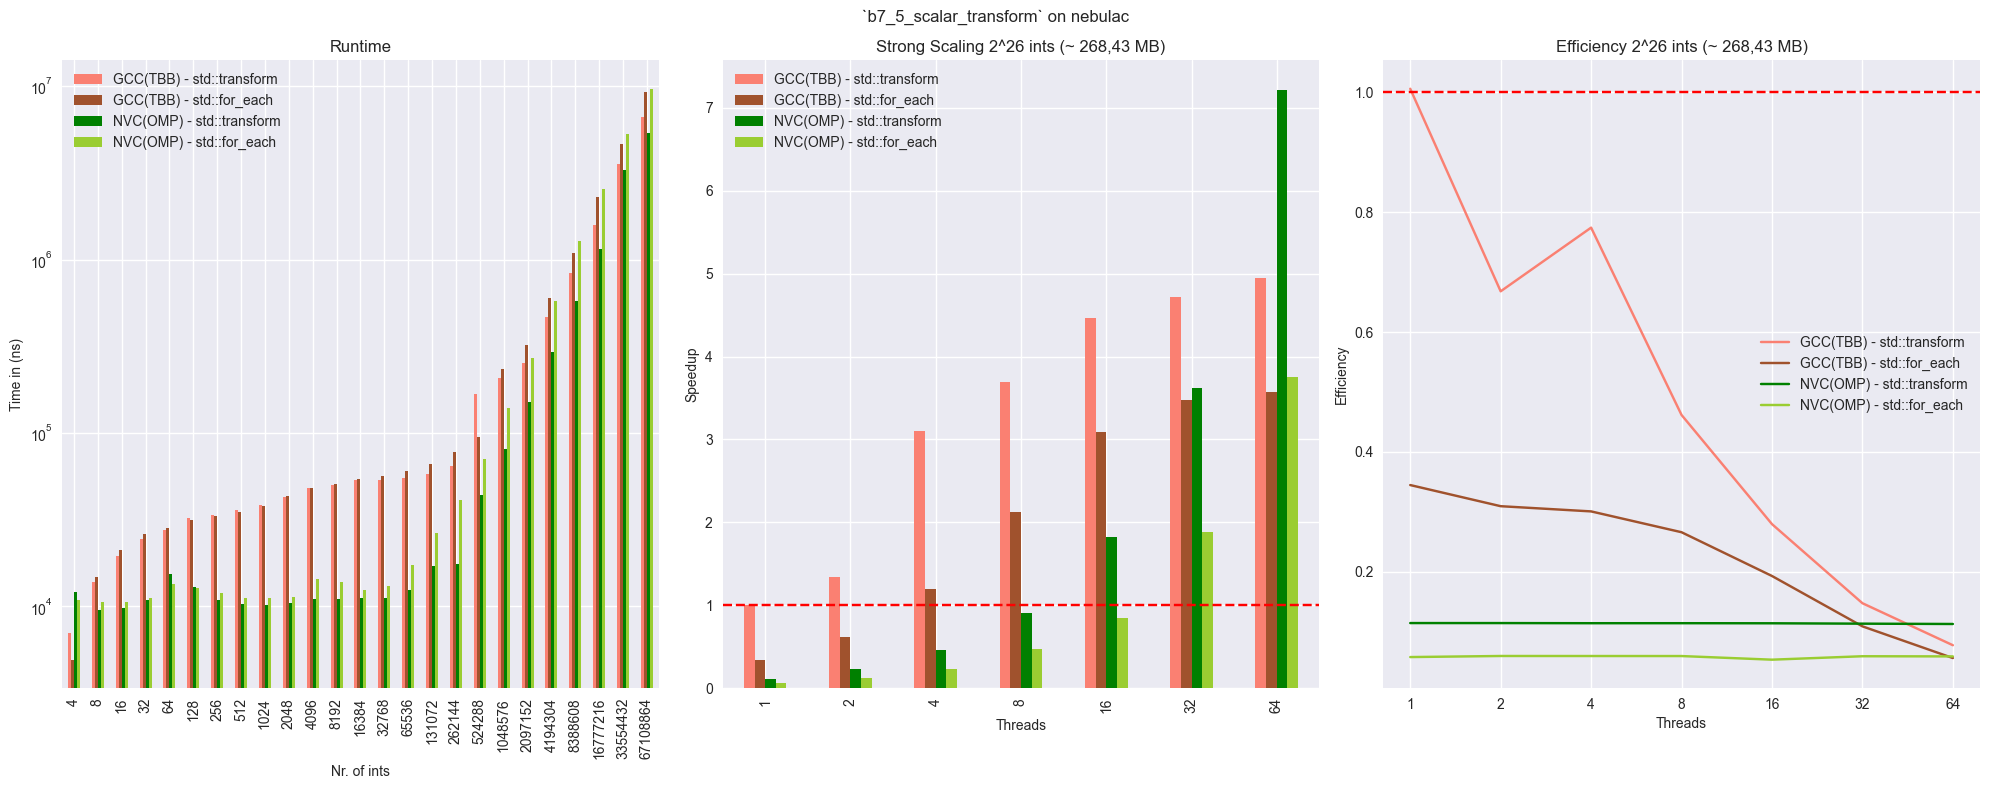

In [114]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_5_scalar_transform` on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` {device_name}")

### Investigation GCC

In [115]:
b7_5_gcc_seq_nebula = extraction_pandas_frame_algo(root_dir + f'/GCC_TBB/DEFAULT/b7_5_scalar_transform_number_seq__Default.csv',COMP='GCC',include_bytes_per_second=True)

b7_5_gcc_seq_nebula = b7_5_gcc_seq_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_gcc_seq_nebula = b7_5_gcc_seq_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_gcc_seq_nebula['NEBULA-BYTES'] = b7_5_gcc_seq_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_gcc_seq_nebula

,NEBULA-TIME,NEBULA-BYTES
0,32851700.0,16.3422


In [116]:
b7_5_gcc_threaded_nebula = extraction_pandas_frame_algo_threaded(f'{root_dir}/GCC_TBB/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_gcc_threaded_nebula = b7_5_gcc_threaded_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_gcc_threaded_nebula = b7_5_gcc_threaded_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_gcc_threaded_nebula['NEBULA-BYTES'] = b7_5_gcc_threaded_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_gcc_threaded_nebula

,NEBULA-TIME,NEBULA-BYTES,threads
0,32648300.0,16.4441,1
1,24587100.0,21.8354,2
2,10605700.0,50.6208,4
3,8895170.0,60.3553,8
4,7347690.0,73.0666,16
5,6965000.0,77.0813,32


In [117]:
b7_5_gcc_threaded_hydra = extraction_pandas_frame_algo_threaded(f'/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/GCC_TBB/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_gcc_threaded_hydra = b7_5_gcc_threaded_hydra.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_gcc_threaded_hydra = b7_5_gcc_threaded_hydra.rename(columns={'real_time':'HYDRA-TIME','bytes_per_second':'HYDRA-BYTES'})

b7_5_gcc_threaded_hydra['HYDRA-BYTES'] = b7_5_gcc_threaded_hydra['HYDRA-BYTES'] / 1_000_000_000

b7_5_gcc_threaded_hydra

,HYDRA-TIME,HYDRA-BYTES,threads
0,47211900.0,11.3715,1
1,24015600.0,22.3551,2
2,14428900.0,37.2079,4
3,10624100.0,50.5332,8
4,8197450.0,65.4925,16
5,8301380.0,64.6725,32


Text(0.5, 1.0, 'GB/s GCC for b7_5_scalar_transform')

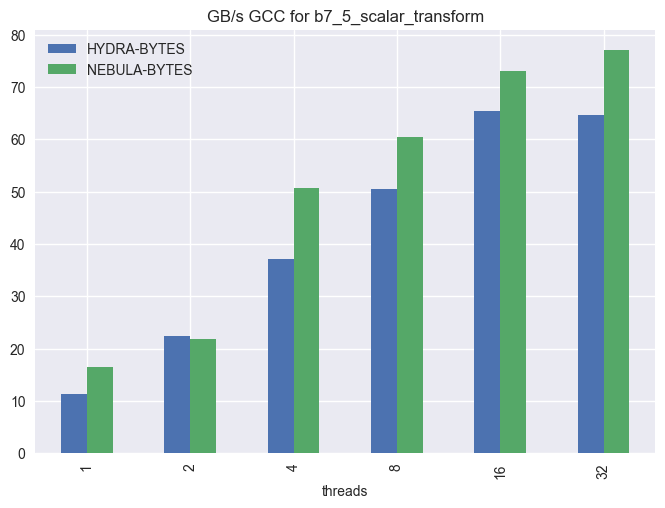

In [118]:
ax = pd.merge(b7_5_gcc_threaded_hydra,b7_5_gcc_threaded_nebula,on='threads').drop(columns=['HYDRA-TIME','NEBULA-TIME']).plot(kind='bar',x='threads')
ax.set_title('GB/s GCC for b7_5_scalar_transform')


In [119]:
def get_numa_node_for_cpu_nebula(cpu_id:int)-> int:
    # the lookup would be more efficient when we have CPU_ID -> NUMA NODE mapping but this is way to much work for this short thing
    numa_data : Dict[int,List[int]] = {
        0: [0, 8, 16, 24, 32, 40, 48, 56],
        1: [2, 10, 18, 26, 34, 42, 50, 58],
        2: [4,20,36,52,12,28,44,60],
        3: [6,22,38,54,14,30,46,62],
        4: [1,17,33,49,9,25,41,57],
        5: [3,19,35,51,11,27,43,59],
        6: [5,21,37,53,13,29,45,61],
        7: [7,23,39,55,15,31,47,63],
    }

    for key in numa_data.keys():
        if cpu_id in numa_data[key]:
            return key
    


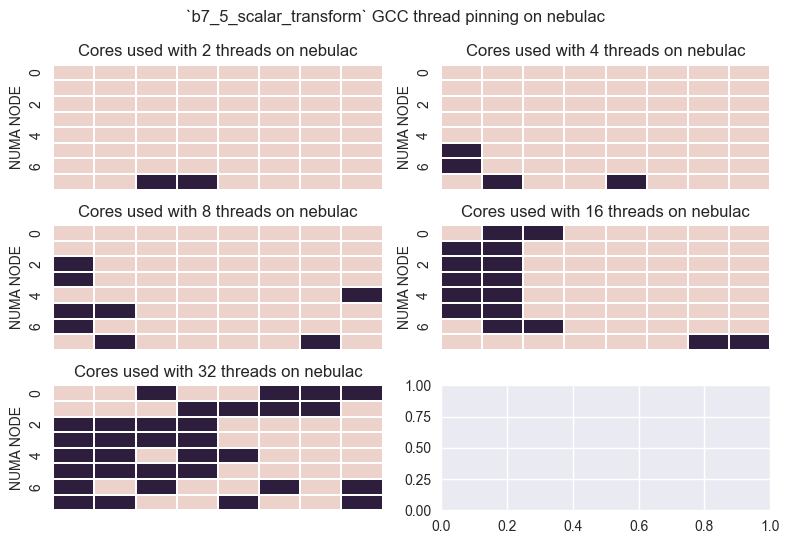

In [120]:
import seaborn as sns

# cpu dist
result: Dict[int,pd.DataFrame] = {}
for i in [2,4,8,16,32]:
    t2= pd.read_csv(f'{root_dir}/GCC_TBB/THREAD_PINNED_CYCLES/b7_5_T{i}.csv',header=None)
    t2 = t2.drop(columns=[2,3,4,5,6,7])

    t2 = t2.rename(columns={0:'CPU',1:'CYCLES'})

    nth_highest_val = t2['CYCLES'].nlargest(i).iloc[-1]

    t2['CYCLES'] = np.where(t2.CYCLES < nth_highest_val,0, 1)

    t2['CPU'] = t2['CPU'].map(lambda x: int(x.lstrip('CPU')))
    t2['NUMA_NODE'] = t2['CPU'].apply(lambda x: get_numa_node_for_cpu_nebula(x))
    
    lvl0 = t2.NUMA_NODE.values
    lvl1 = t2.CPU.values

    t2 = t2.drop(columns=['NUMA_NODE','CPU'])

    index = pd.MultiIndex.from_arrays([lvl0, lvl1], names=['NUMA NODE','CPU'])
    t2 = t2.set_index(index)

    result[i] = t2

fig, axs = plt.subplots(ncols=2, nrows=3)

positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
counter = 0
for i in [2,4,8,16,32]:
    pos = positions[counter]
    ax = axs[pos[0]][pos[1]]
    
    heatmap_df = result[i].reset_index().pivot(columns='CPU',index='NUMA NODE',values='CYCLES')

    heatmap_df = pd.DataFrame(justify(heatmap_df.values, invalid_val=np.nan, side='left', axis=1), 
                    columns=heatmap_df.columns,index=heatmap_df.index)

    heatmap_df = heatmap_df.dropna(axis='columns')
    heatmap_df = heatmap_df.fillna(0)

    ax = sns.heatmap(heatmap_df,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,ax=ax,cbar=False,linewidths=0.05)

    ax.set_title(f'Cores used with {i} threads on {device_name}')
    ax.get_xaxis().set_visible(False)
    counter = counter + 1


fig.suptitle(f"`b7_5_scalar_transform` GCC thread pinning on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` GCC thread pinning on {device_name}")

### Investigation NVC

In [121]:
b7_5_nvc_omp_nebula = extraction_pandas_frame_algo(root_dir + f'/NVHPC_Multicore/DEFAULT/b7_5_scalar_transform_number_seq__Default.csv',COMP='GCC',include_bytes_per_second=True)

b7_5_nvc_omp_nebula = b7_5_nvc_omp_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_nebula = b7_5_nvc_omp_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_nvc_omp_nebula['NEBULA-BYTES'] = b7_5_nvc_omp_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_nebula

,NEBULA-TIME,NEBULA-BYTES
0,64965900.0,8.26389


In [122]:
b7_5_nvc_omp_threaded_nebula = extraction_pandas_frame_algo_threaded(f'{root_dir}/NVHPC_Multicore/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_nvc_omp_threaded_nebula = b7_5_nvc_omp_threaded_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_threaded_nebula = b7_5_nvc_omp_threaded_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_nvc_omp_threaded_nebula['NEBULA-BYTES'] = b7_5_nvc_omp_threaded_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_threaded_nebula

,NEBULA-TIME,NEBULA-BYTES,threads
0,287527000.0,1.86720,1
1,143789000.0,3.73374,2
2,72030900.0,7.45334,4
3,36009700.0,14.90910,8
4,18027500.0,29.78060,16
5,9064600.0,59.22720,32


In [123]:
b7_5_nvc_omp_hydra = extraction_pandas_frame_algo('/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/NVHPC_Multicore/DEFAULT/b7_5_scalar_transform_number_seq__Default.csv',COMP='GCC',include_bytes_per_second=True)

b7_5_nvc_omp_hydra = b7_5_nvc_omp_hydra.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_hydra = b7_5_nvc_omp_hydra.rename(columns={'real_time':'HYDRA-TIME','bytes_per_second':'HYDRA-BYTES'})

b7_5_nvc_omp_hydra['HYDRA-BYTES'] = b7_5_nvc_omp_hydra['HYDRA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_hydra

,HYDRA-TIME,HYDRA-BYTES
0,68959100.0,7.78535


In [124]:
b7_5_nvc_omp_threaded_hydra = extraction_pandas_frame_algo_threaded(f'/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/GCC_TBB/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_nvc_omp_threaded_hydra = b7_5_nvc_omp_threaded_hydra.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_threaded_hydra = b7_5_nvc_omp_threaded_hydra.rename(columns={'real_time':'HYDRA-TIME','bytes_per_second':'HYDRA-BYTES'})

b7_5_nvc_omp_threaded_hydra['HYDRA-BYTES'] = b7_5_nvc_omp_threaded_hydra['HYDRA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_threaded_hydra

,HYDRA-TIME,HYDRA-BYTES,threads
0,47211900.0,11.3715,1
1,24015600.0,22.3551,2
2,14428900.0,37.2079,4
3,10624100.0,50.5332,8
4,8197450.0,65.4925,16
5,8301380.0,64.6725,32


Text(0.5, 1.0, 'GB/s NVC(OMP) for b7_5_scalar_transform')

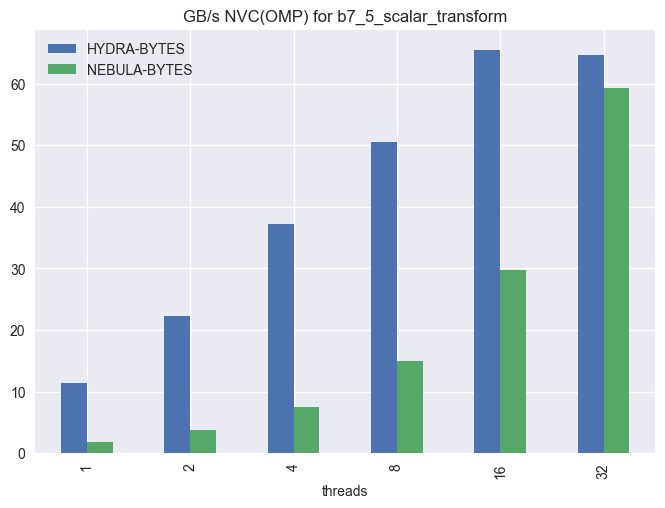

In [125]:
ax = pd.merge(b7_5_nvc_omp_threaded_hydra,b7_5_nvc_omp_threaded_nebula,on='threads').drop(columns=['HYDRA-TIME','NEBULA-TIME']).plot(kind='bar',x='threads')
ax.set_title('GB/s NVC(OMP) for b7_5_scalar_transform')


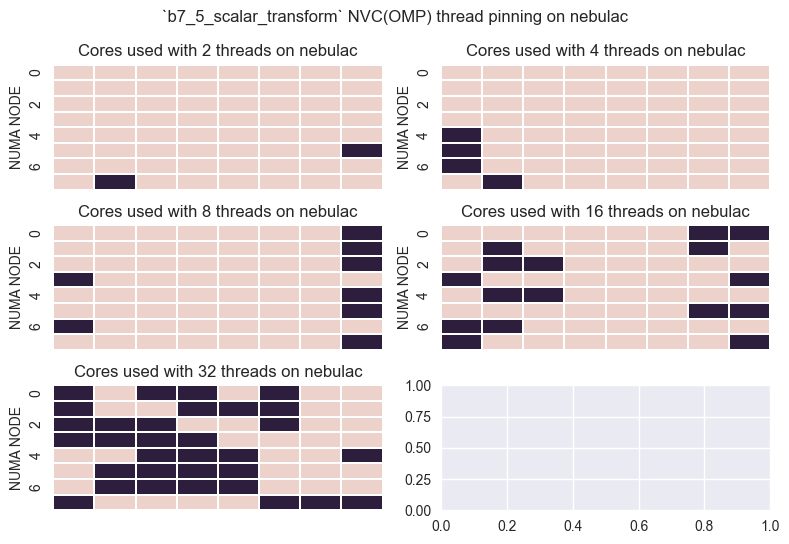

In [126]:
import seaborn as sns

# cpu dist
result: Dict[int,pd.DataFrame] = {}
for i in [2,4,8,16,32]:
    t2= pd.read_csv(f'{root_dir}/NVHPC_Multicore/THREAD_PINNED_CYCLES/b7_5_T{i}.csv',header=None)
    t2 = t2.drop(columns=[2,3,4,5,6,7])

    t2 = t2.rename(columns={0:'CPU',1:'CYCLES'})

    nth_highest_val = t2['CYCLES'].nlargest(i).iloc[-1]

    t2['CYCLES'] = np.where(t2.CYCLES < nth_highest_val,0, 1)

    t2['CPU'] = t2['CPU'].map(lambda x: int(x.lstrip('CPU')))
    t2['NUMA_NODE'] = t2['CPU'].apply(lambda x: get_numa_node_for_cpu_nebula(x))
    
    lvl0 = t2.NUMA_NODE.values
    lvl1 = t2.CPU.values

    t2 = t2.drop(columns=['NUMA_NODE','CPU'])

    index = pd.MultiIndex.from_arrays([lvl0, lvl1], names=['NUMA NODE','CPU'])
    t2 = t2.set_index(index)

    result[i] = t2

fig, axs = plt.subplots(ncols=2, nrows=3)

positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
counter = 0
for i in [2,4,8,16,32]:
    pos = positions[counter]
    ax = axs[pos[0]][pos[1]]
    
    heatmap_df = result[i].reset_index().pivot(columns='CPU',index='NUMA NODE',values='CYCLES')

    heatmap_df = pd.DataFrame(justify(heatmap_df.values, invalid_val=np.nan, side='left', axis=1), 
                    columns=heatmap_df.columns,index=heatmap_df.index)

    heatmap_df = heatmap_df.dropna(axis='columns')
    heatmap_df = heatmap_df.fillna(0)

    ax = sns.heatmap(heatmap_df,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,ax=ax,cbar=False,linewidths=0.05)
    ax.set_title(f'Cores used with {i} threads on {device_name}')
    ax.get_xaxis().set_visible(False)
    counter = counter + 1

fig.suptitle(f"`b7_5_scalar_transform` NVC(OMP) thread pinning on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` NVC(OMP) thread pinning on {device_name}")

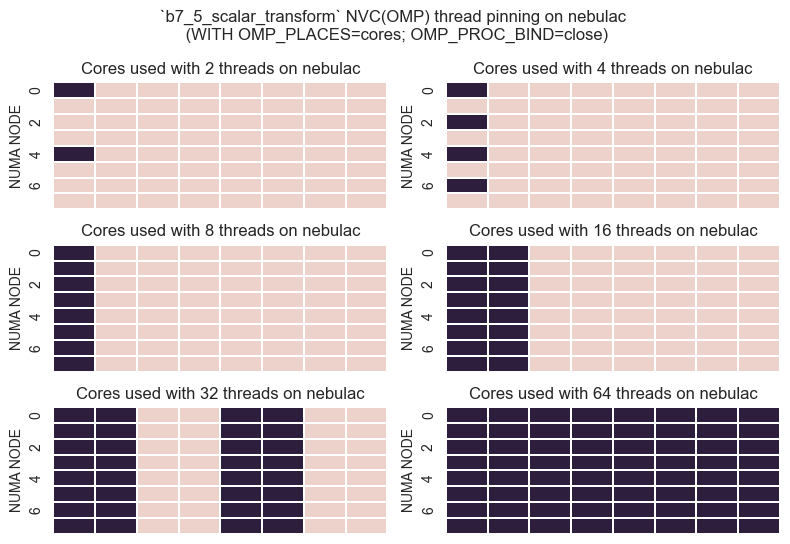

In [127]:
import seaborn as sns

# cpu dist
result: Dict[int,pd.DataFrame] = {}
for i in [2,4,8,16,32,64]:
    t2= pd.read_csv(f'{root_dir}/NVHPC_Multicore/THREAD_PINNED_CYCLES/b7_5_EXTRA_T{i}.csv',header=None)
    t2 = t2.drop(columns=[2,3,4,5,6,7])

    t2 = t2.rename(columns={0:'CPU',1:'CYCLES'})

    nth_highest_val = t2['CYCLES'].nlargest(i).iloc[-1]

    t2['CYCLES'] = np.where(t2.CYCLES < nth_highest_val,0, 1)

    t2['CPU'] = t2['CPU'].map(lambda x: int(x.lstrip('CPU')))
    t2['NUMA_NODE'] = t2['CPU'].apply(lambda x: get_numa_node_for_cpu_nebula(x))
    
    lvl0 = t2.NUMA_NODE.values
    lvl1 = t2.CPU.values

    t2 = t2.drop(columns=['NUMA_NODE','CPU'])

    index = pd.MultiIndex.from_arrays([lvl0, lvl1], names=['NUMA NODE','CPU'])
    t2 = t2.set_index(index)

    result[i] = t2

fig, axs = plt.subplots(ncols=2, nrows=3)

positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
counter = 0
for i in [2,4,8,16,32,64]:
    pos = positions[counter]
    ax = axs[pos[0]][pos[1]]
    
    heatmap_df = result[i].reset_index().pivot(columns='CPU',index='NUMA NODE',values='CYCLES')

    heatmap_df = pd.DataFrame(justify(heatmap_df.values, invalid_val=np.nan, side='left', axis=1), 
                    columns=heatmap_df.columns,index=heatmap_df.index)

    heatmap_df = heatmap_df.dropna(axis='columns')
    heatmap_df = heatmap_df.fillna(0)

    ax = sns.heatmap(heatmap_df,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,ax=ax,cbar=False,linewidths=0.05)
    ax.set_title(f'Cores used with {i} threads on {device_name}')
    ax.get_xaxis().set_visible(False)
    counter = counter + 1

fig.suptitle(f"`b7_5_scalar_transform` NVC(OMP) thread pinning on {device_name} \n (WITH OMP_PLACES=cores; OMP_PROC_BIND=close)")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` NVC(OMP) (WITH OMP_PLACES=cores; OMP_PROC_BIND=close) thread pinning on {device_name}")

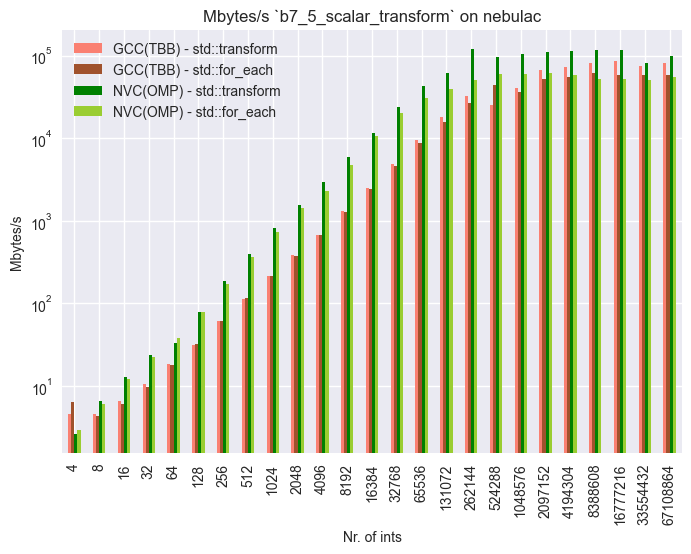

In [128]:

# mbytes graph

b7_5_scalar_transform_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_5_scalar_transform` on {device_name}')


plot(f'`b7_5_scalar_transform` Mbytes_s on {device_name}')

## `b7_6` - Serial vs direct call

In [129]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

strong_scale_base = 'b7_6_transform_reduce'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [130]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,2009.44,4,8094.57,22643.6,32357.1
1,6804.75,8,22393.90,20509.4,32145.9
2,11725.70,16,37807.80,21381.7,33243.8
3,17250.50,32,48784.00,22532.4,35858.9
4,22307.90,64,57497.70,24972.9,38176.5
5,26179.70,128,62530.60,24963.9,37316.1
6,32484.60,256,66597.10,25052.8,36774.1
7,33822.60,512,70715.90,23774.4,37698.2
8,35551.40,1024,76736.60,24153.0,40423.4
9,38089.40,2048,86933.30,23161.8,42241.4


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [131]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.998880,0.487131,0.656209,0.193243
1,2,1.886041,0.647877,1.320960,0.346663
2,4,3.078187,0.820391,2.613799,0.538545
3,8,4.383217,0.722632,5.176800,0.631779
4,16,6.175666,0.601109,10.062407,0.577997
5,32,7.081103,0.694571,17.090288,0.542446
6,64,7.562312,0.658947,18.167550,0.560893


In [132]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.998880,0.487131,0.656209,0.193243
1,2,0.943020,0.323938,0.660480,0.173331
2,4,0.769547,0.205098,0.653450,0.134636
3,8,0.547902,0.090329,0.647100,0.078972
4,16,0.385979,0.037569,0.628900,0.036125
5,32,0.221284,0.021705,0.534072,0.016951
6,64,0.118161,0.010296,0.283868,0.008764


### Mbytes/s   

In [133]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_6_transform_reduce_vs_serial_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_bytes_merged = pd.merge(b7_6_transform_reduce_vs_serial_bytes_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_bytes_merged

,n,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4,15.92480,11.85980,1.41320,2.96689
1,8,9.40519,8.57375,3.12053,5.97277
2,16,10.91620,10.15660,5.98644,11.55100
3,32,14.84010,15.74290,11.36140,21.41730
4,64,22.95150,26.71410,20.50220,40.23420
5,128,39.11430,49.12790,41.01930,82.32380
6,256,63.04530,92.25630,81.74720,167.07400
7,512,121.10200,173.76600,172.28600,325.95700
8,1024,230.42700,320.26400,339.17100,607.96500
9,2048,430.14600,565.39900,707.37200,1163.60000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7412/182734503.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


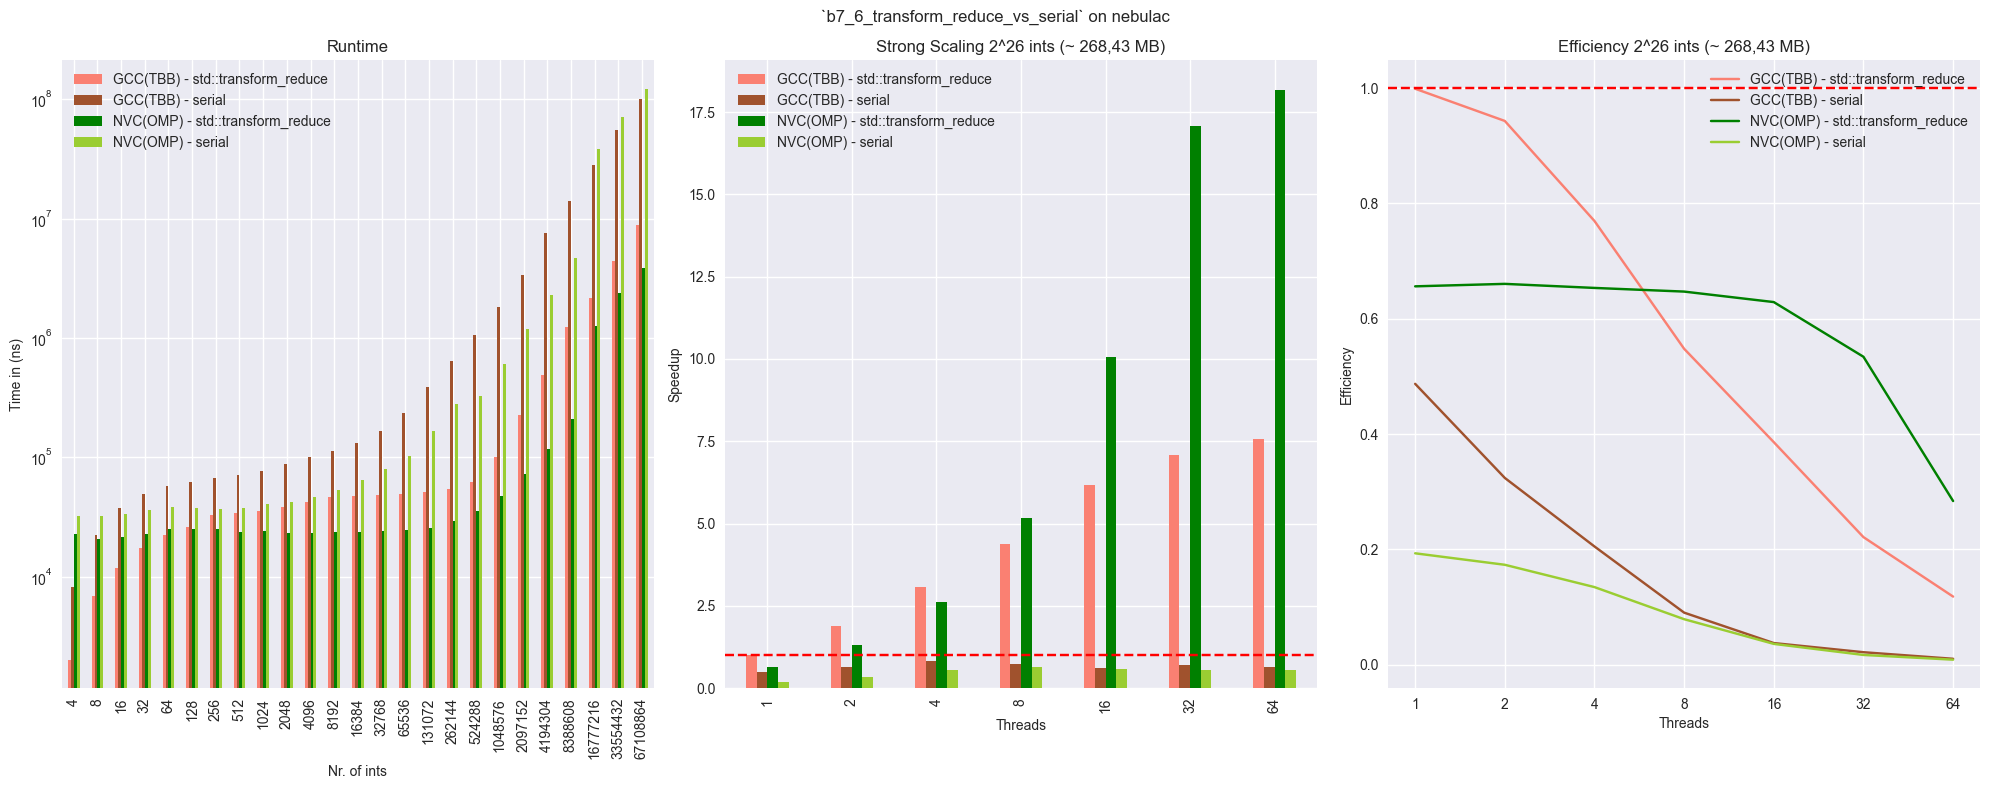

In [134]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_6_transform_reduce_vs_serial` on {device_name}")

fig.tight_layout()

plot(f"`b7_6_transform_reduce_vs_serial` {device_name}")

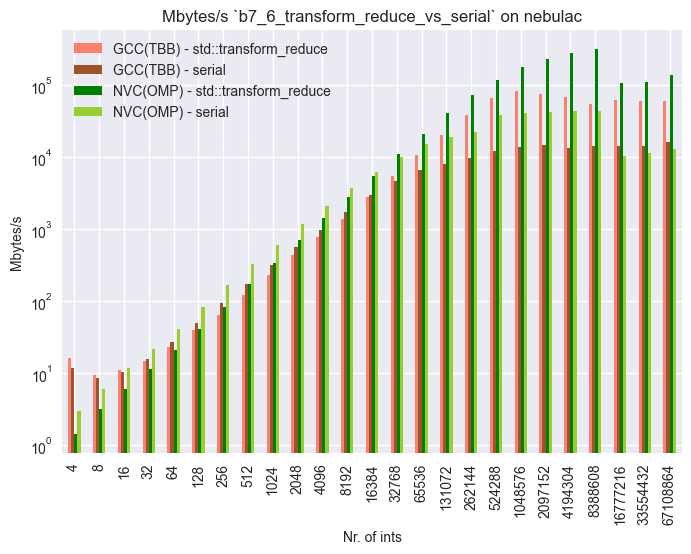

In [135]:
# mbytes graph

b7_6_transform_reduce_vs_serial_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_6_transform_reduce_vs_serial` on {device_name}')


plot(f'`b7_6_transform_reduce_vs_serial` Mbytes_s on {device_name}')

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [136]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b7_1_copy',b7_1_time_merged, [' - std::copy', ' - std::foreach']),
    
    ('b7_2_all_of_all_true',b7_2_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_first_false',b7_2_first_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_last_false',b7_2_last_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_auto_false',b7_2_auto_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),


    ('b7_3_count_if_all_hit',b7_3_all_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_half_hit',b7_3_half_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_orders_struct',b7_3_orders_struct_time_merged, [' - std::count_if', ' - std::transform_reduce']),

    
    ('b7_4_stencil_transform',b7_4_stencil_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_5_scalar_transform',b7_5_scalar_transform_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_6_transform_reduce',b7_6_transform_reduce_vs_serial_time_merged, [' - std::transform_reduce', ' - serial']),
]


for root_display_name, data_source, suffixes in data_fields:

    for suffix in suffixes:
        entry_dict = {
            'name': [root_display_name + suffix],
        }

        vals = []

        # getting the data from the source for each compiler
        for comp in compilers:
            current_val = int(data_source.iloc[-1][comp + suffix])
            entry_dict[comp] = [current_val]

            vals.append(current_val)

        entry_dict['PP'] = calc_pp(vals)

        other_df = pd.DataFrame.from_dict(entry_dict)
        pp_df = pd.concat([pp_df,other_df],ignore_index=True)



pp_df['Percentage'] = pp_df['PP']

pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')


pp_df_styled = pp_df.style.format({'Percentage': "{:.2%}"})
pp_df_styled

,name,GCC(TBB),NVC(OMP),PP,Percentage,INTERPRET
0,b7_1_copy - std::copy,7176600,8333080,0.925435,92.54%,GOOD
1,b7_1_copy - std::foreach,9852350,9347920,0.973728,97.37%,GOOD
2,b7_2_all_of_all_true - std::all_of,2942250,10904100,0.424986,42.50%,BAD
3,b7_2_all_of_all_true - std::transform_reduce,3102490,2189980,0.827583,82.76%,BAD
4,b7_2_all_of_first_false - std::all_of,25988,77096,0.504210,50.42%,BAD
5,b7_2_all_of_first_false - std::transform_reduce,3112660,2169380,0.821417,82.14%,BAD
6,b7_2_all_of_last_false - std::all_of,2585130,11056900,0.378995,37.90%,BAD
7,b7_2_all_of_last_false - std::transform_reduce,3055860,2245940,0.847237,84.72%,BAD
8,b7_2_all_of_auto_false - std::all_of,23298,54256,0.600820,60.08%,BAD
9,b7_2_all_of_auto_false - std::transform_reduce,227071,24012,0.191267,19.13%,BAD


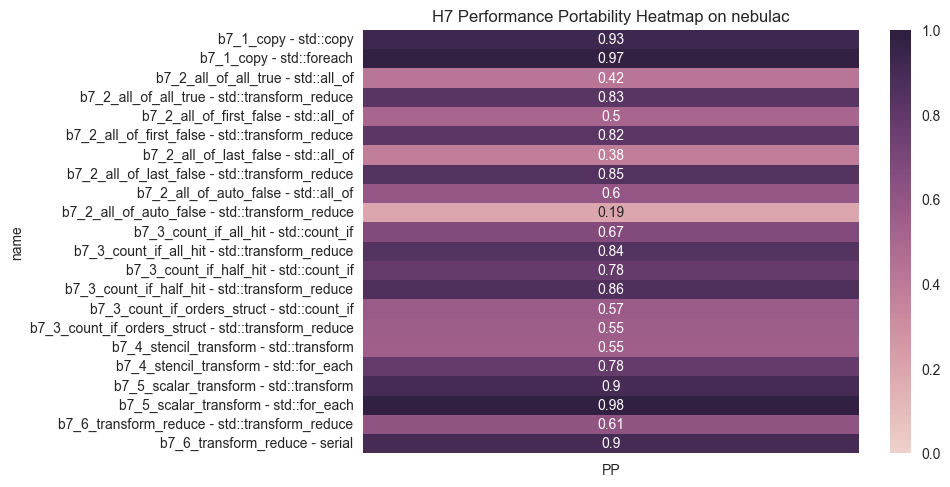

In [137]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','Percentage','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H7 Performance Portability Heatmap on {device_name}')

plot(f'H7 Performance Portability Heatmap on {device_name}')

## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


